**Authors**: Céline Hirsch, Sandra Frey, Sina Röllin

**Deep Learning Project**: Inclusiveness in Sarcasm Detection

In [1]:
from functions_audio_model_tiny import *
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import json
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean
from sklearn.model_selection import ParameterGrid

In [2]:
class SpectrogramDataset(Dataset):
    def __init__(self, spectrogram_dir, labels):
        self.spectrogram_dir = spectrogram_dir
        self.file_list = [f for f in os.listdir(spectrogram_dir) if f.endswith('_red.npy')]
        self.labels = labels  #dictionary mapping base file names to labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        #to get the base name of the file (without the color channel)
        base_name = self.file_list[idx].replace('_red.npy', '')

        #All colour channels separately
        red_channel = np.load(os.path.join(self.spectrogram_dir, base_name + '_red.npy'))
        green_channel = np.load(os.path.join(self.spectrogram_dir, base_name + '_green.npy'))
        blue_channel = np.load(os.path.join(self.spectrogram_dir, base_name + '_blue.npy'))

        #Stack the color channels to create RGB image
        spectrogram = np.stack((red_channel, green_channel, blue_channel), axis=2)

        #Conversion to tensor
        spectrogram = torch.from_numpy(spectrogram)

        #Normalisation to range [-1, 1]
        spectrogram = (spectrogram - 0.5) * 2

        #Label
        label = self.labels[base_name]

        return spectrogram, label

In [3]:
# Load labels for sarcasm detection (from a different file, not part of the spectrograms folder)
with open('data/audio/labels_mixed.json', 'r') as f:
    mixed_labels = json.load(f)

with open('data/audio/labels_F.json', 'r') as f:
    F_labels = json.load(f)

with open('data/audio/labels_M.json', 'r') as f:
    M_labels = json.load(f)

In [4]:
# Initialise the datasets
mixed_dataset = SpectrogramDataset('data/spectrograms/spectrograms_mixed/', mixed_labels)
M_dataset = SpectrogramDataset('data/spectrograms/spectrograms_M/', M_labels)
F_dataset = SpectrogramDataset('data/spectrograms/spectrograms_F/', F_labels)


Start of epoch 0
Training acc over epoch: 0.6628
Training F1 score over epoch: 0.6568
Training loss over epoch: 0.7709
Validation acc: 0.6337
Validation F1 score: 0.6501
Validation loss: 0.7363

Start of epoch 1
Training acc over epoch: 0.6802
Training F1 score over epoch: 0.6658
Training loss over epoch: 0.6011
Validation acc: 0.6337
Validation F1 score: 0.6623
Validation loss: 0.6911

Start of epoch 2
Training acc over epoch: 0.6991
Training F1 score over epoch: 0.6812
Training loss over epoch: 0.5382
Validation acc: 0.6415
Validation F1 score: 0.6797
Validation loss: 0.6636

Start of epoch 3
Training acc over epoch: 0.7118
Training F1 score over epoch: 0.6925
Training loss over epoch: 0.5129
Validation acc: 0.6497
Validation F1 score: 0.6915
Validation loss: 0.6617

Start of epoch 4
Training acc over epoch: 0.7233
Training F1 score over epoch: 0.7032
Training loss over epoch: 0.4952
Validation acc: 0.6535
Validation F1 score: 0.7017
Validation loss: 0.6728

Start of epoch 5
Trainin

TypeError: Object of type EagerTensor is not JSON serializable

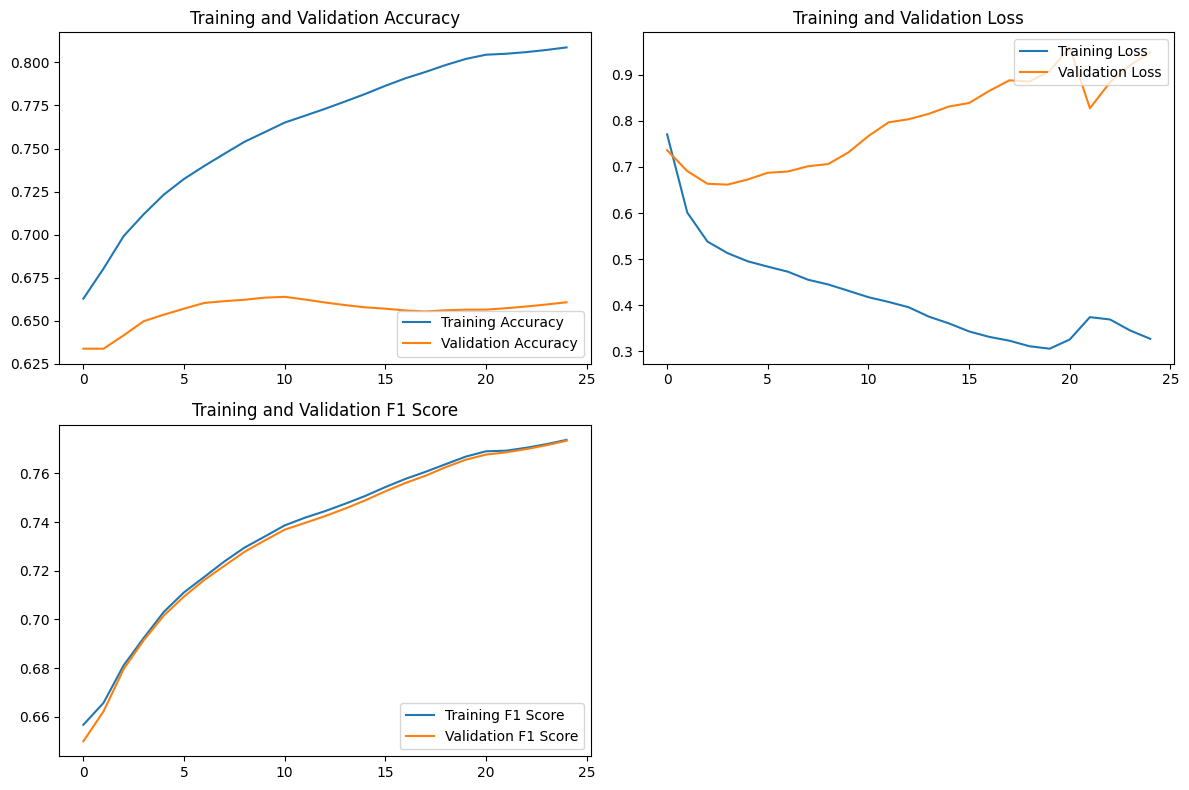

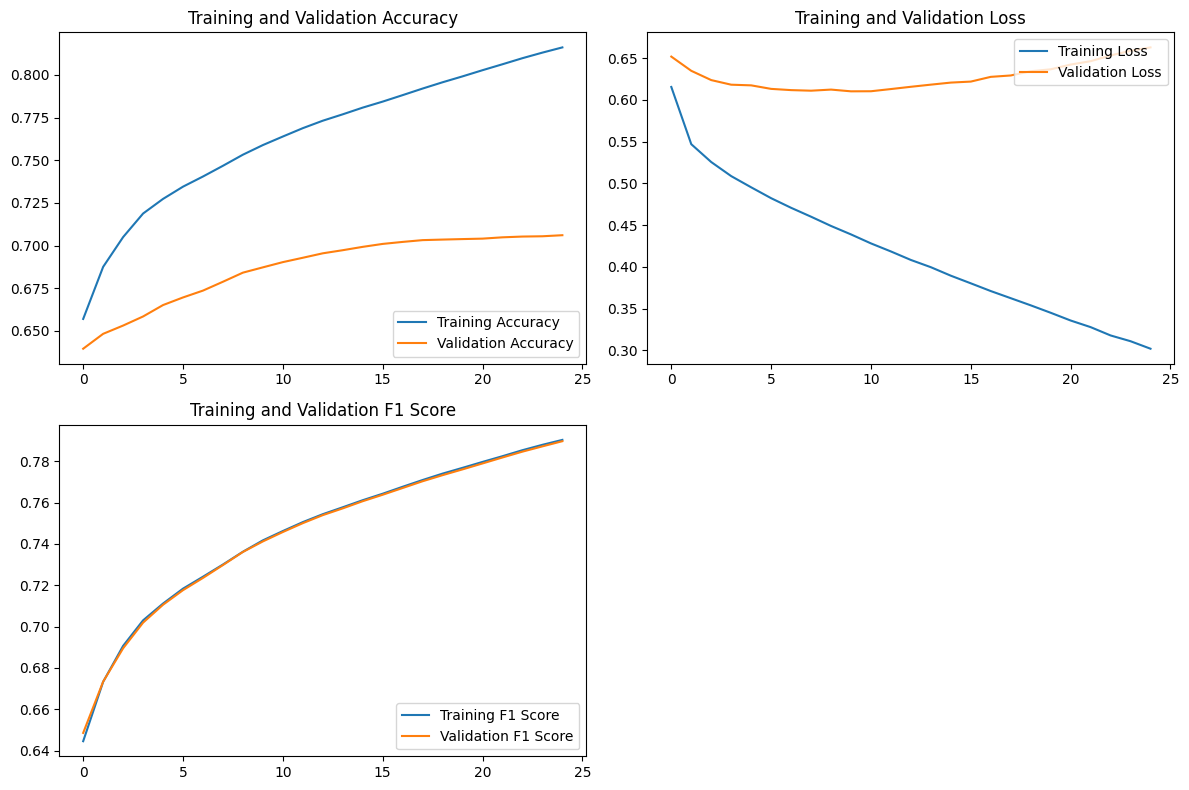

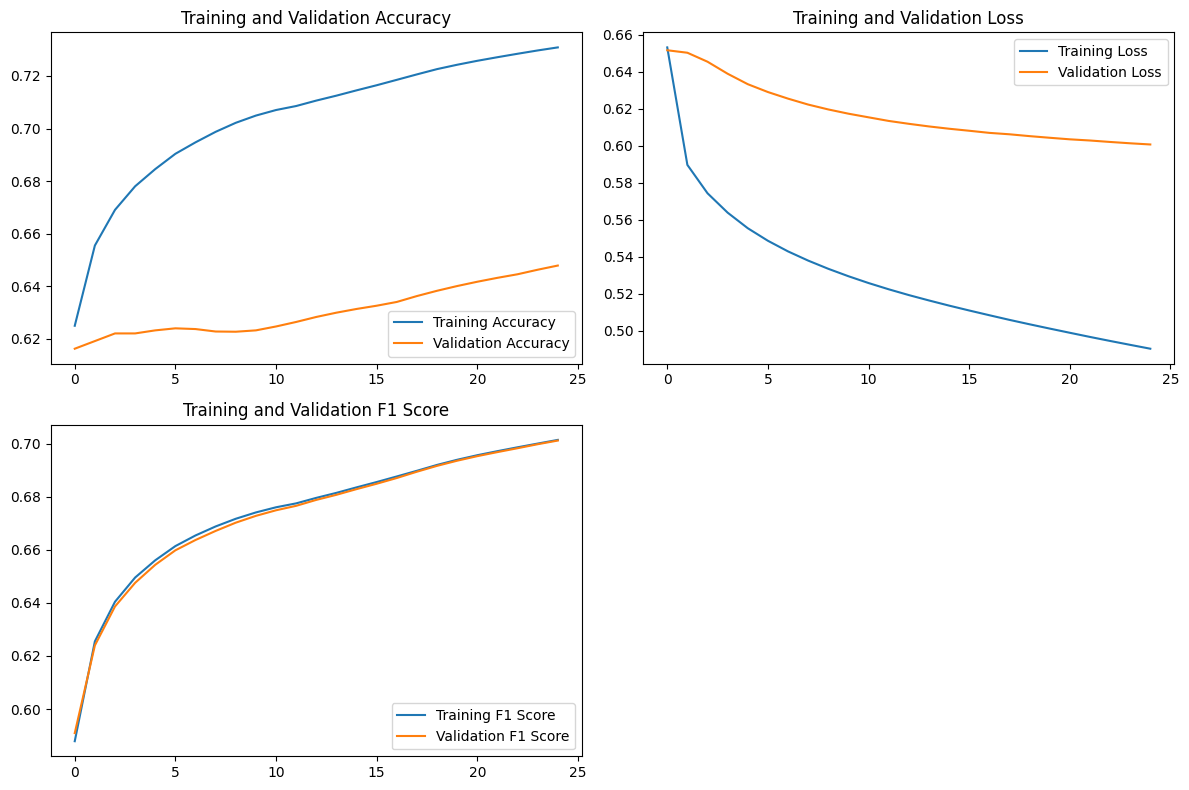

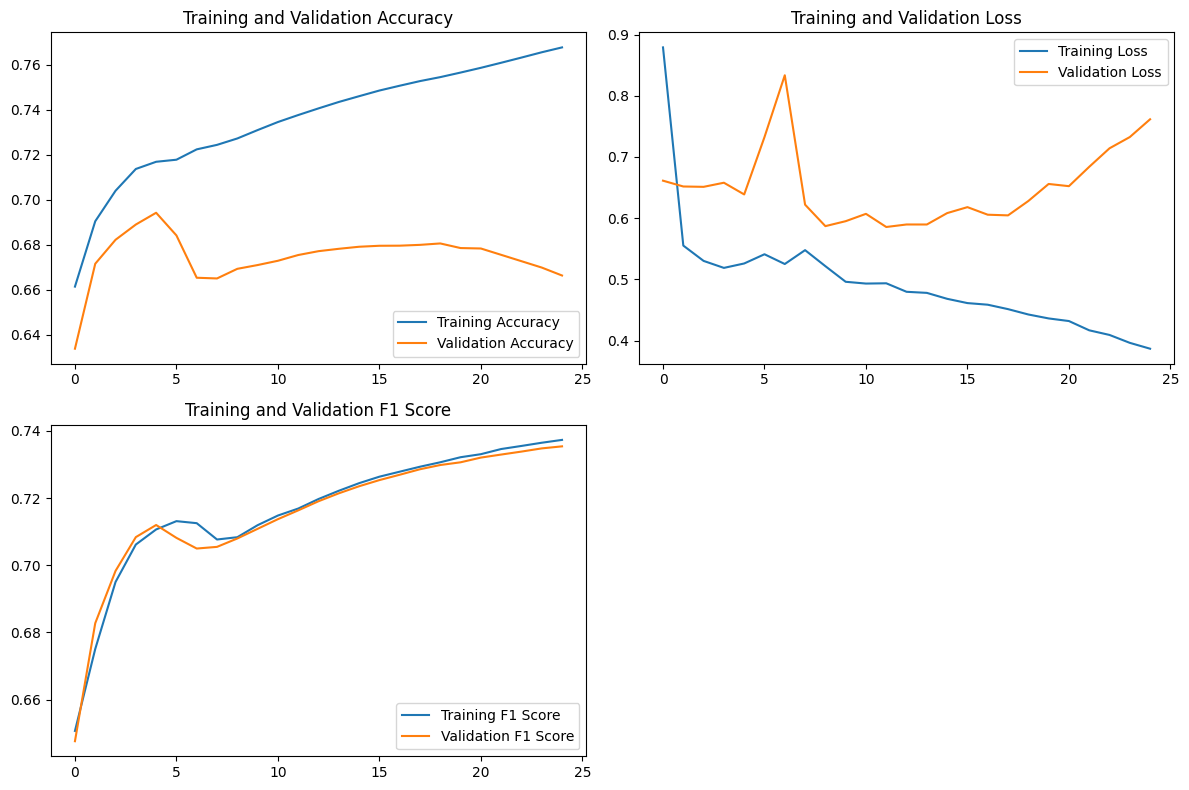

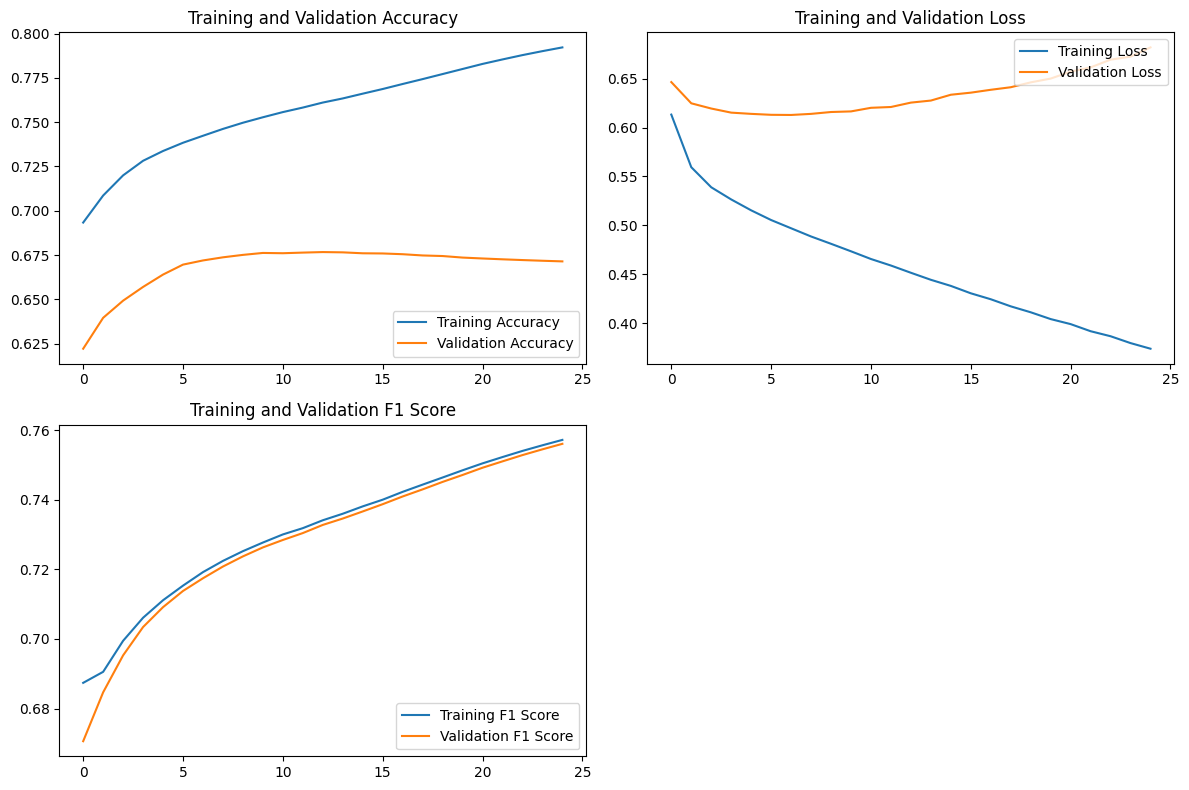

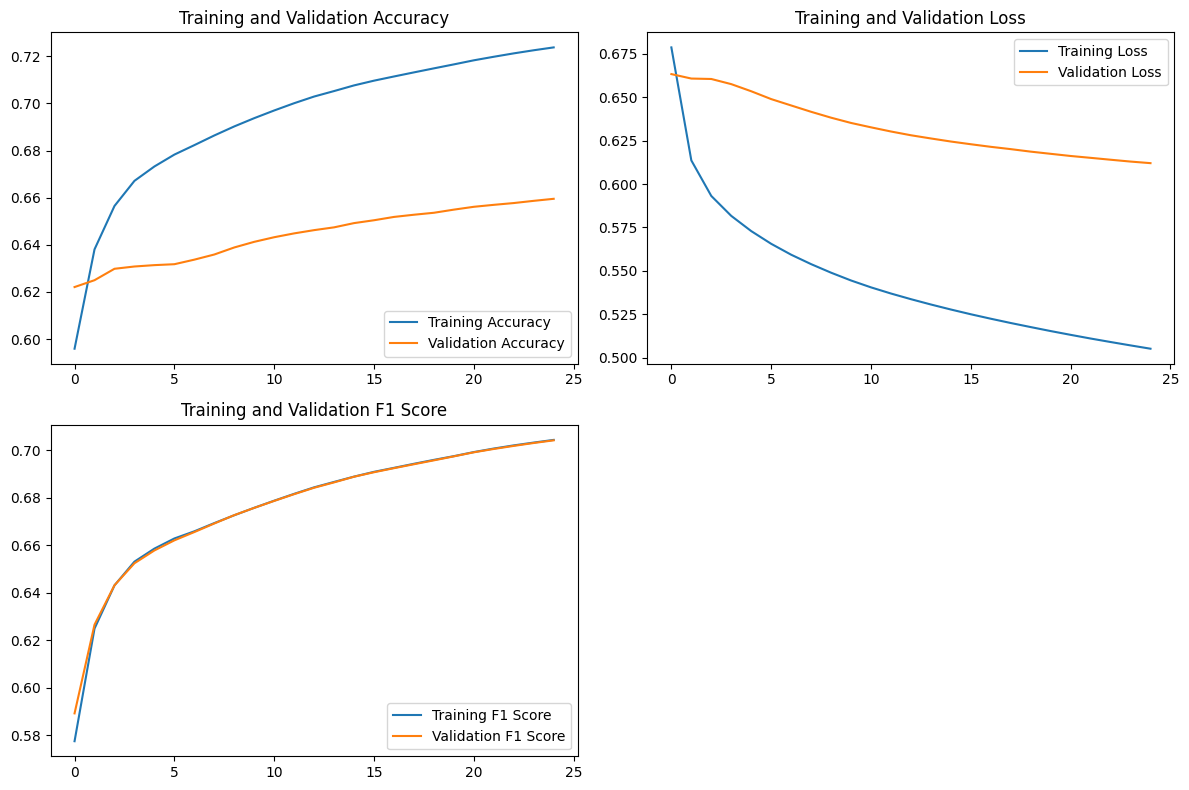

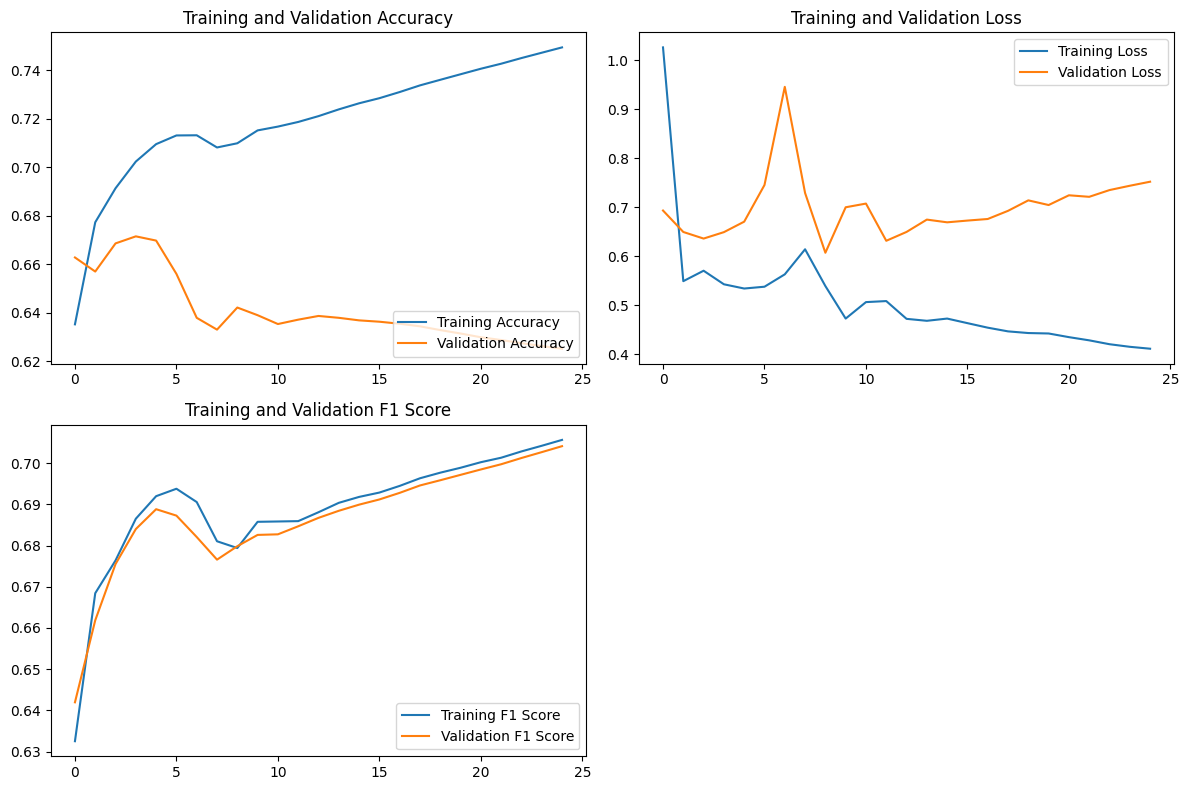

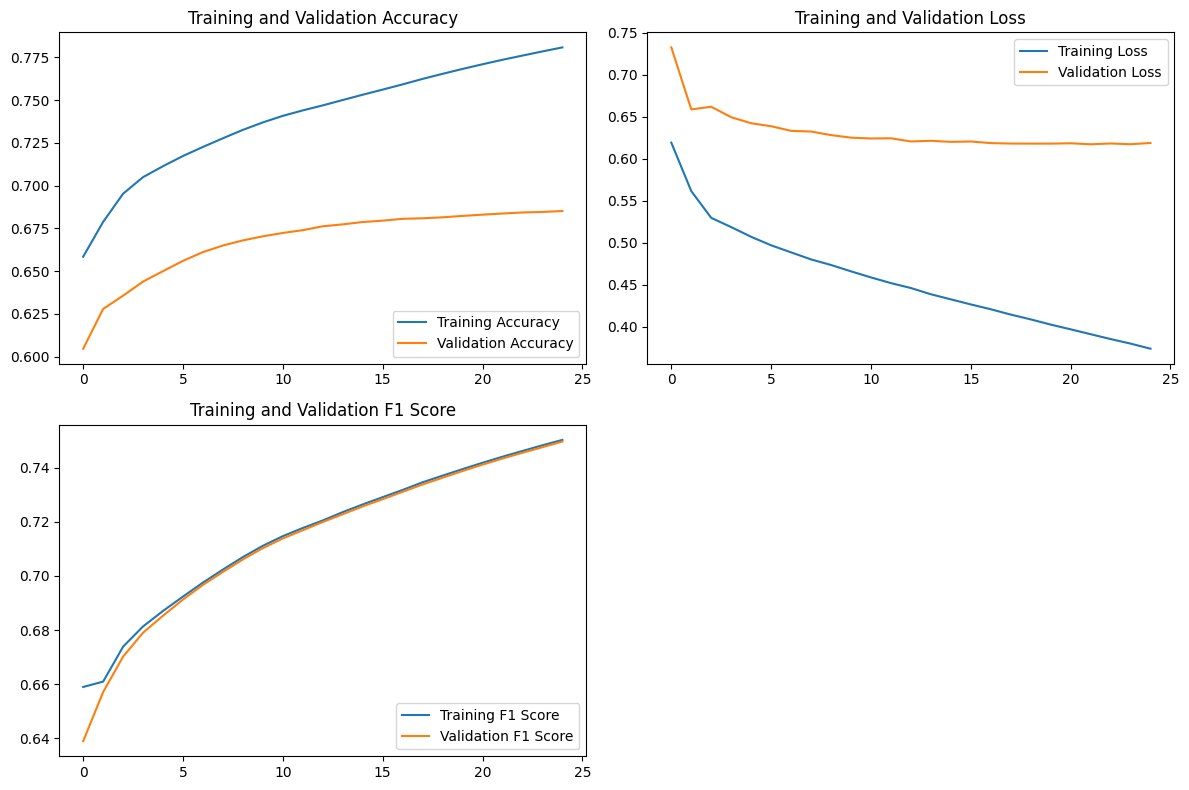

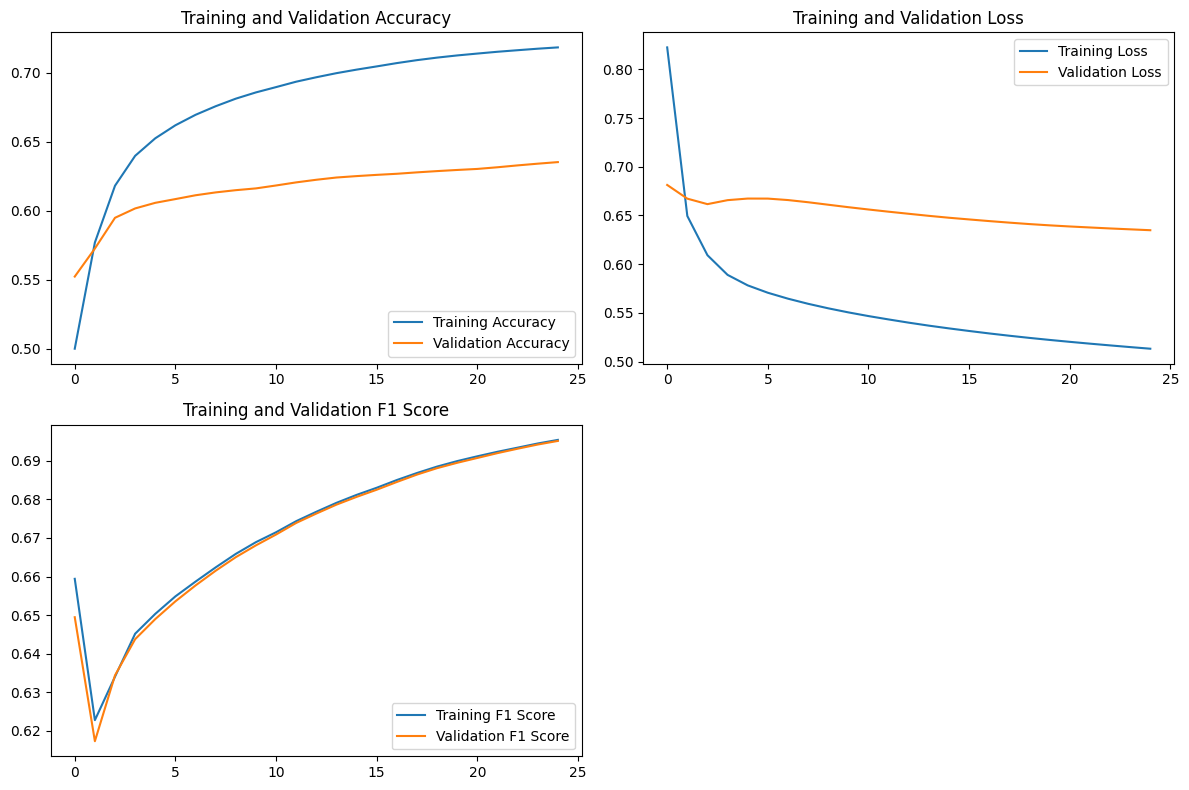

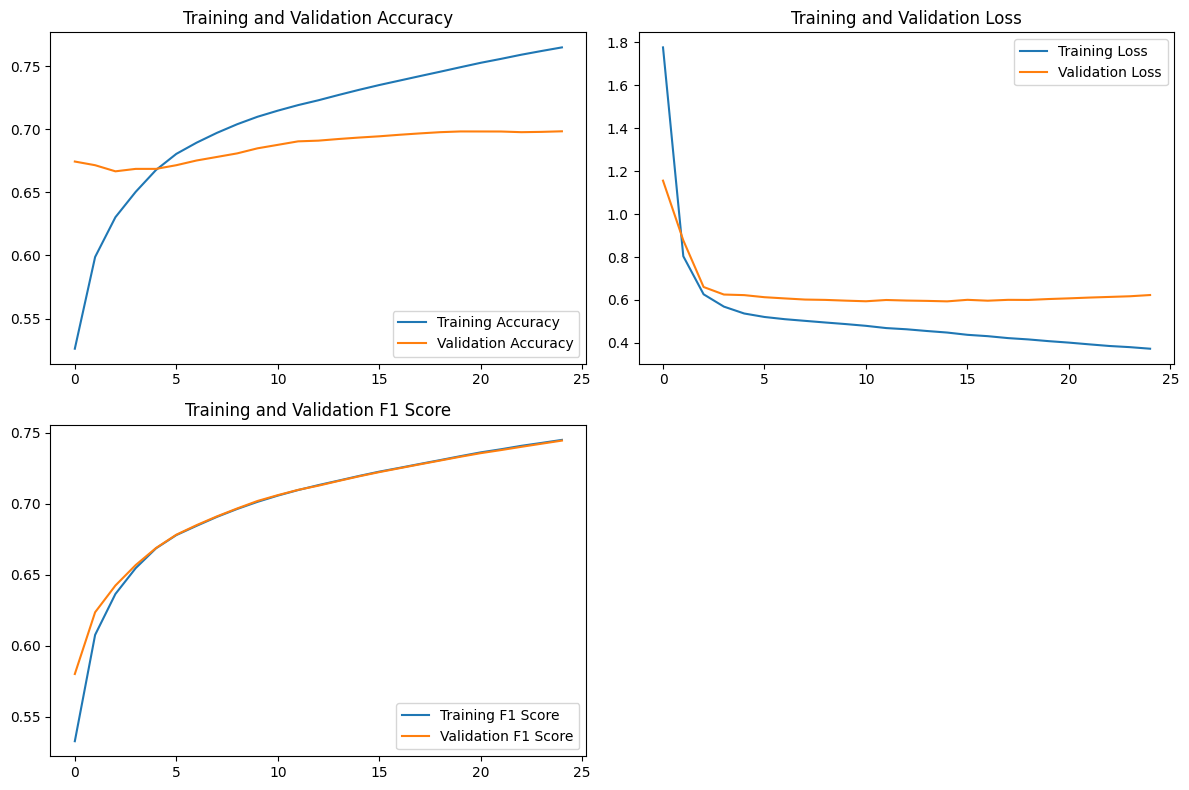

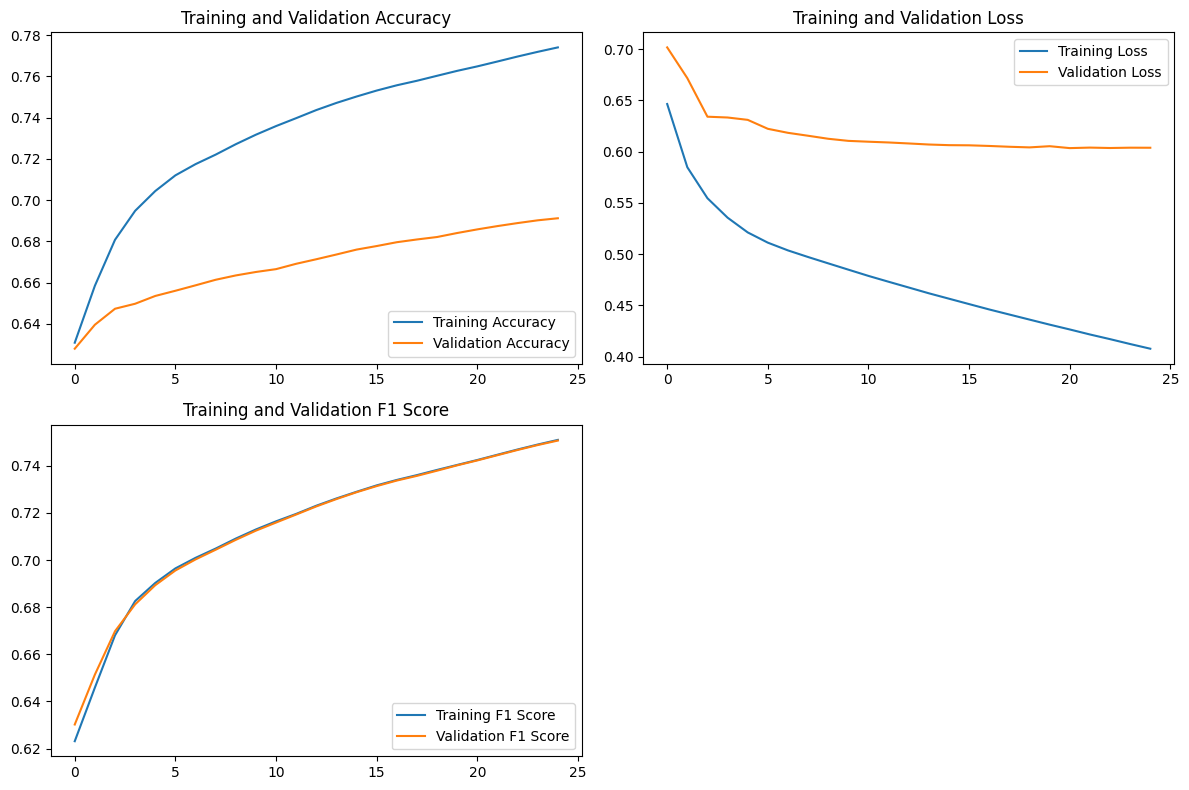

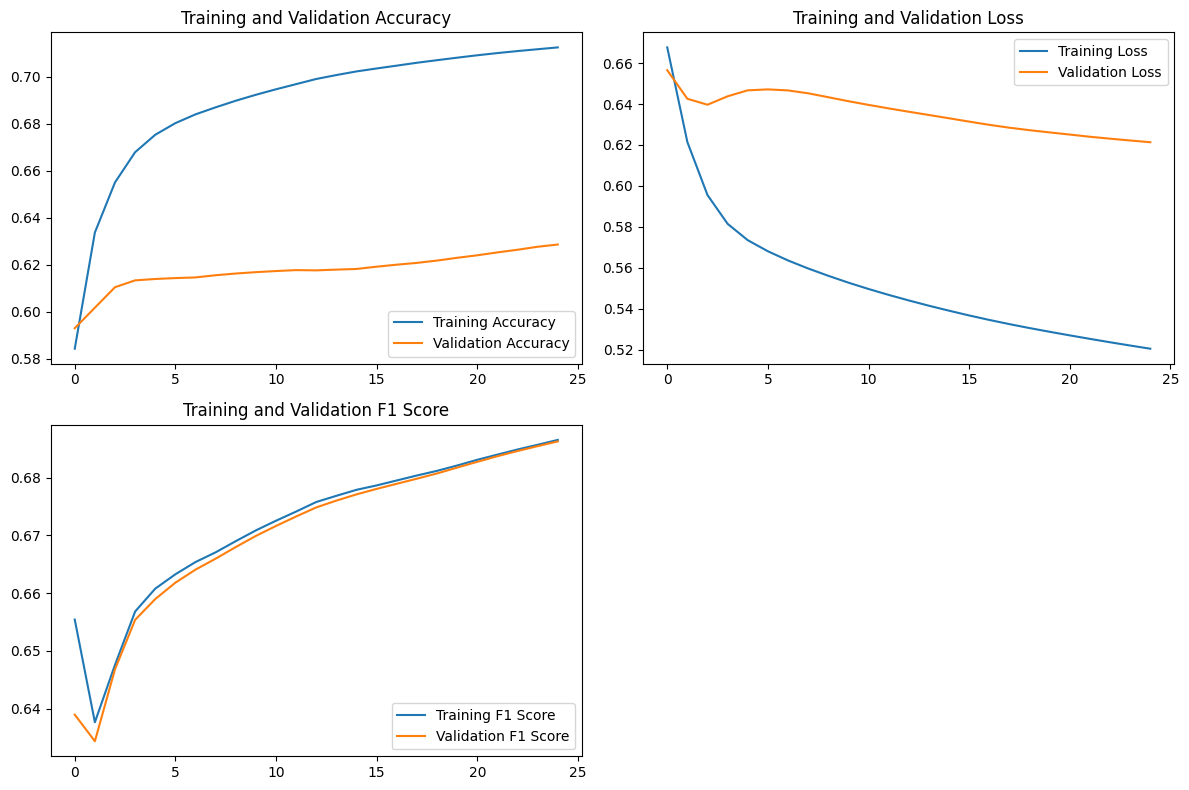

In [5]:
# Set seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters to tune
param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'num_epochs': [25],
    'batch_size': [8, 16, 32, 64],
    'dropout_prob': [0]
}

# Create a parameter grid
grid = ParameterGrid(param_grid)

# Initialize a list to store the results
results = []

# Split dataset into training and testing
train_size = int(0.8 * len(mixed_dataset))  # 80% of the data for training
test_size = len(mixed_dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(mixed_dataset, [train_size, test_size])

# For each combination of hyperparameters
for params in grid:
    # Initialize the DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'])
    test_dataloader = DataLoader(test_dataset, batch_size=params['batch_size'])

    # Initialize the model (pre-trained MobileNetV2)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)  # Two classes for classification

    mixed_model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create the optimizer
    optimizer = Adam(learning_rate=params['lr'])

    # Define the loss function
    loss_fn = SparseCategoricalCrossentropy()

    # Define the metrics
    train_acc_metric = SparseCategoricalAccuracy()
    val_acc_metric = SparseCategoricalAccuracy()

    train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s = train_cycle(mixed_model, optimizer, loss_fn, train_acc_metric, val_acc_metric, train_dataloader, test_dataloader, epochs=params['num_epochs'])
    name = 'mixed_lr' + str(params['lr']) + '_bs_' + str(params['batch_size'])
    plot_metrics(train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s, plot_name=name)

    # Store the results
    results.append({
        'lr': params['lr'],
        'batch_size': params['batch_size'],
        'num_epochs': params['num_epochs'],
        'eval_loss': val_losses,
        'acc': val_accs,
        'f1': val_f1s
    })

with open('hyperparameter_tuning/audio_hyperparameter_tuning_mixed.json', 'w') as f:
    json.dump(results, f, indent=4)


Start of epoch 0
Training acc over epoch: 0.6358
Training F1 score over epoch: 0.6194
Training loss over epoch: 1.1103
Validation acc: 0.6829
Validation F1 score: 0.6250
Validation loss: 0.6692

Start of epoch 1
Training acc over epoch: 0.7160
Training F1 score over epoch: 0.6884
Training loss over epoch: 0.4440
Validation acc: 0.7439
Validation F1 score: 0.7034
Validation loss: 0.4492

Start of epoch 2
Training acc over epoch: 0.7449
Training F1 score over epoch: 0.7238
Training loss over epoch: 0.4361
Validation acc: 0.7642
Validation F1 score: 0.7320
Validation loss: 0.4502

Start of epoch 3
Training acc over epoch: 0.7531
Training F1 score over epoch: 0.7357
Training loss over epoch: 0.4470
Validation acc: 0.7744
Validation F1 score: 0.7411
Validation loss: 0.4495

Start of epoch 4
Training acc over epoch: 0.7617
Training F1 score over epoch: 0.7478
Training loss over epoch: 0.4559
Validation acc: 0.7707
Validation F1 score: 0.7484
Validation loss: 0.5062

Start of epoch 5
Trainin

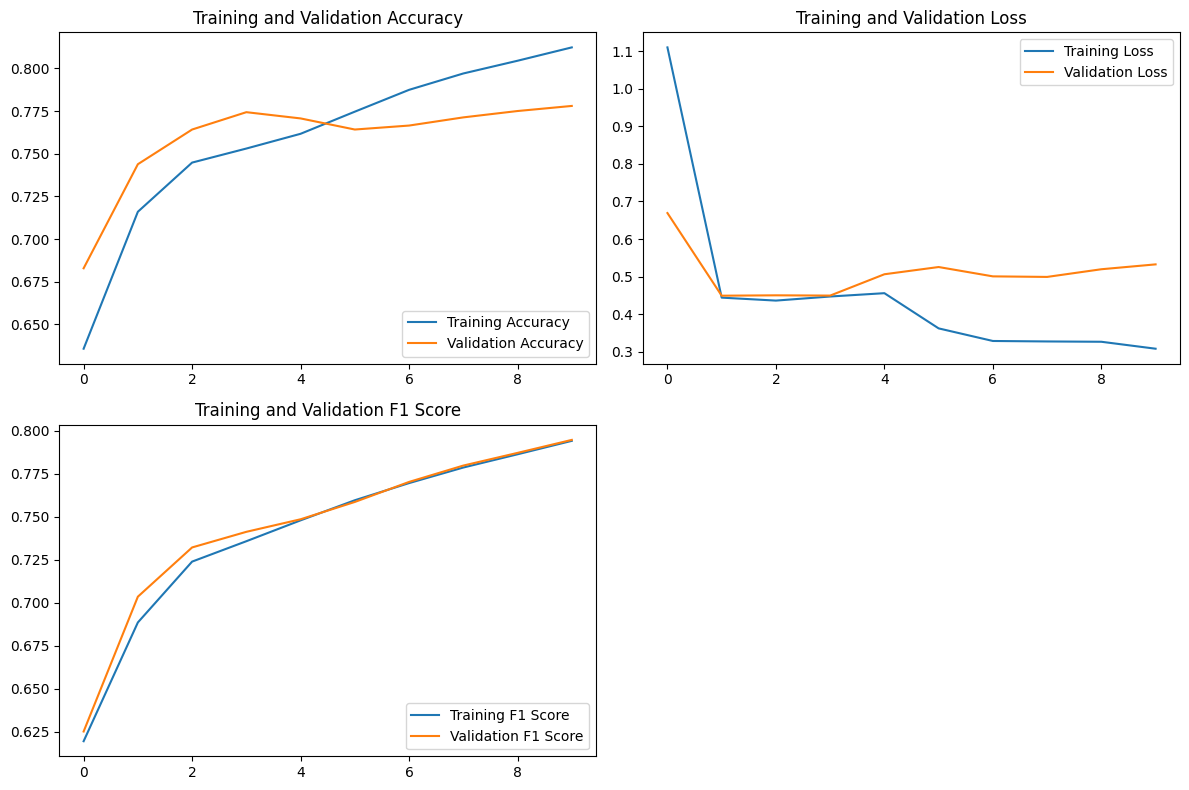

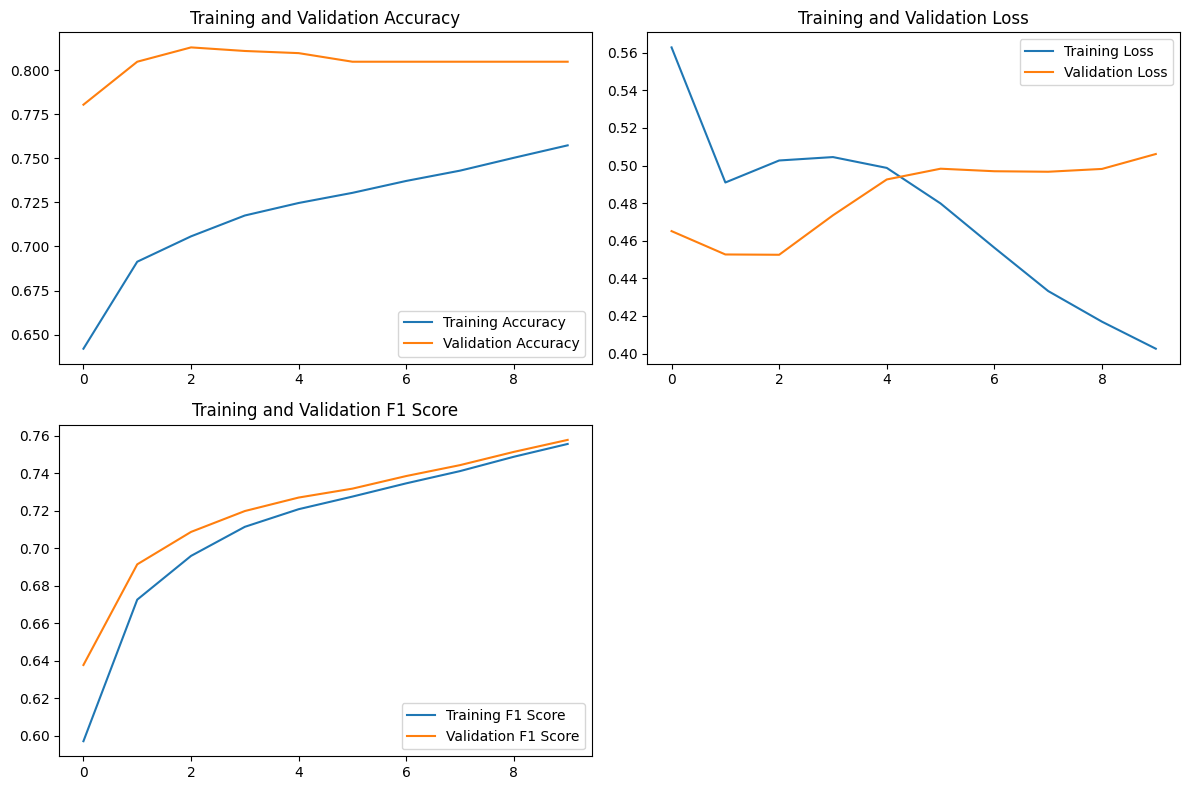

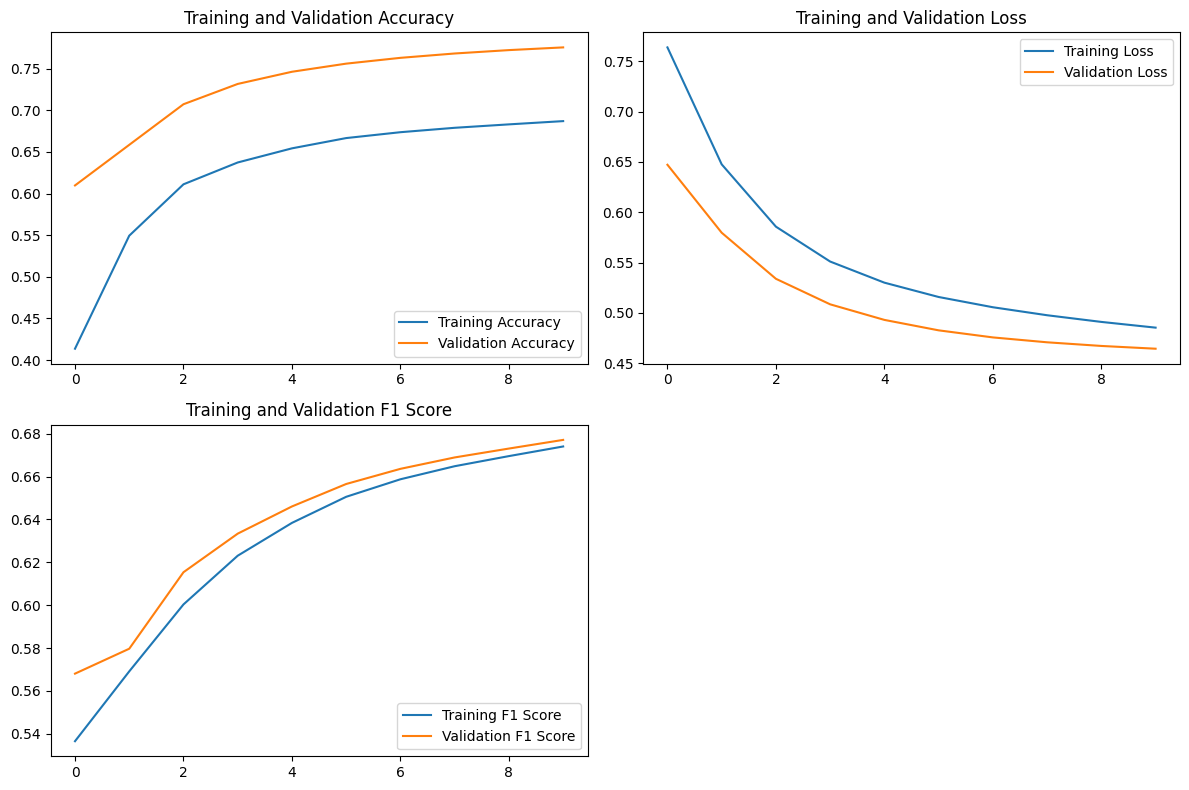

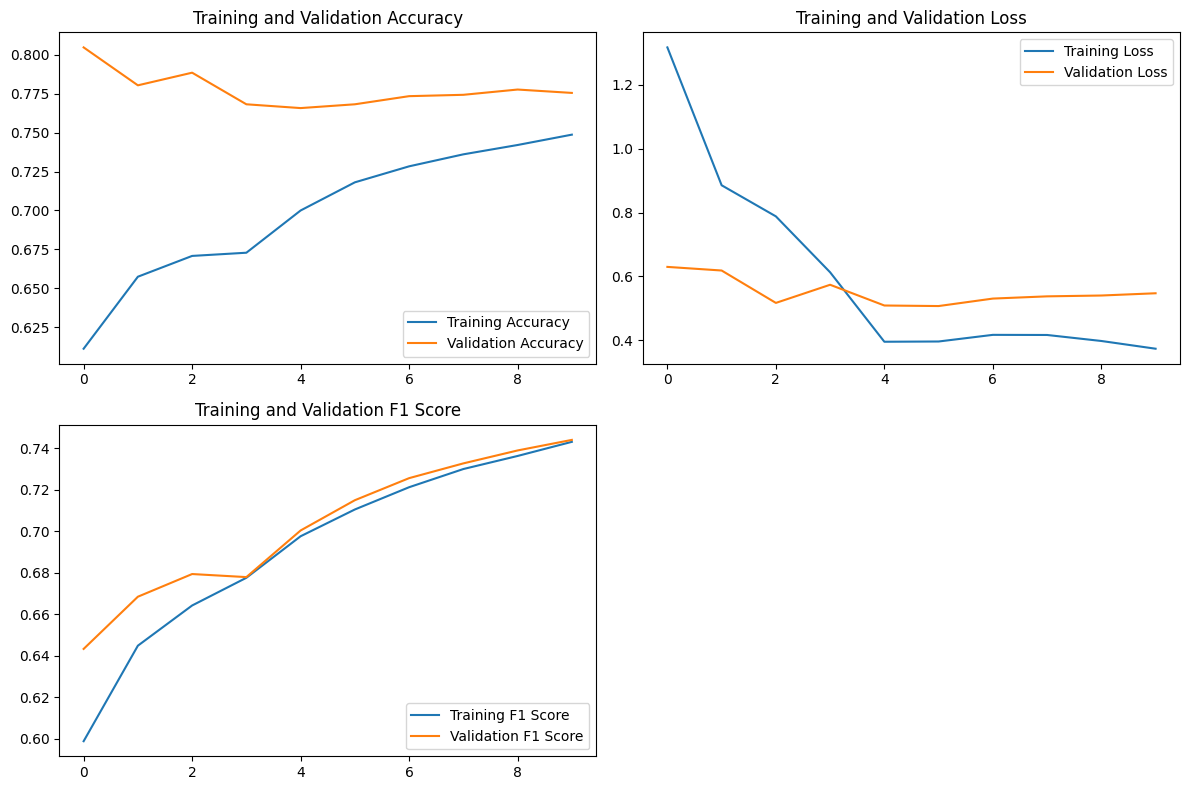

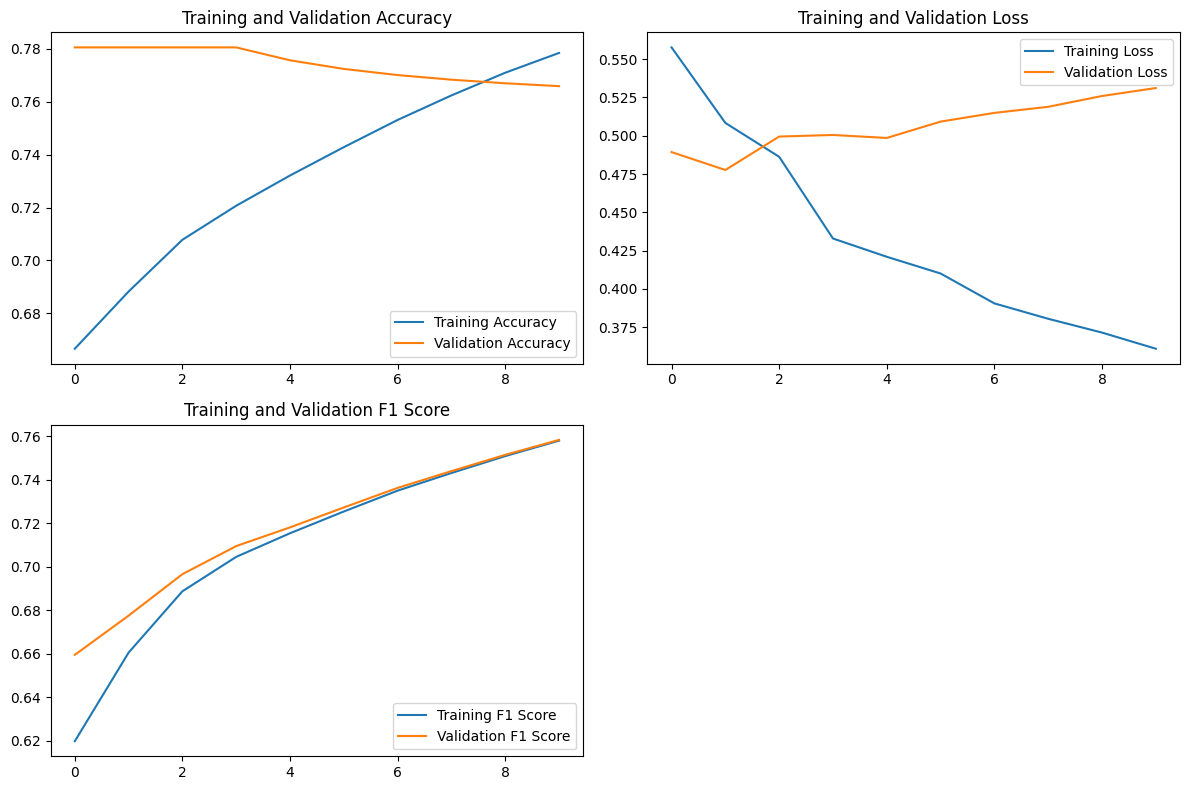

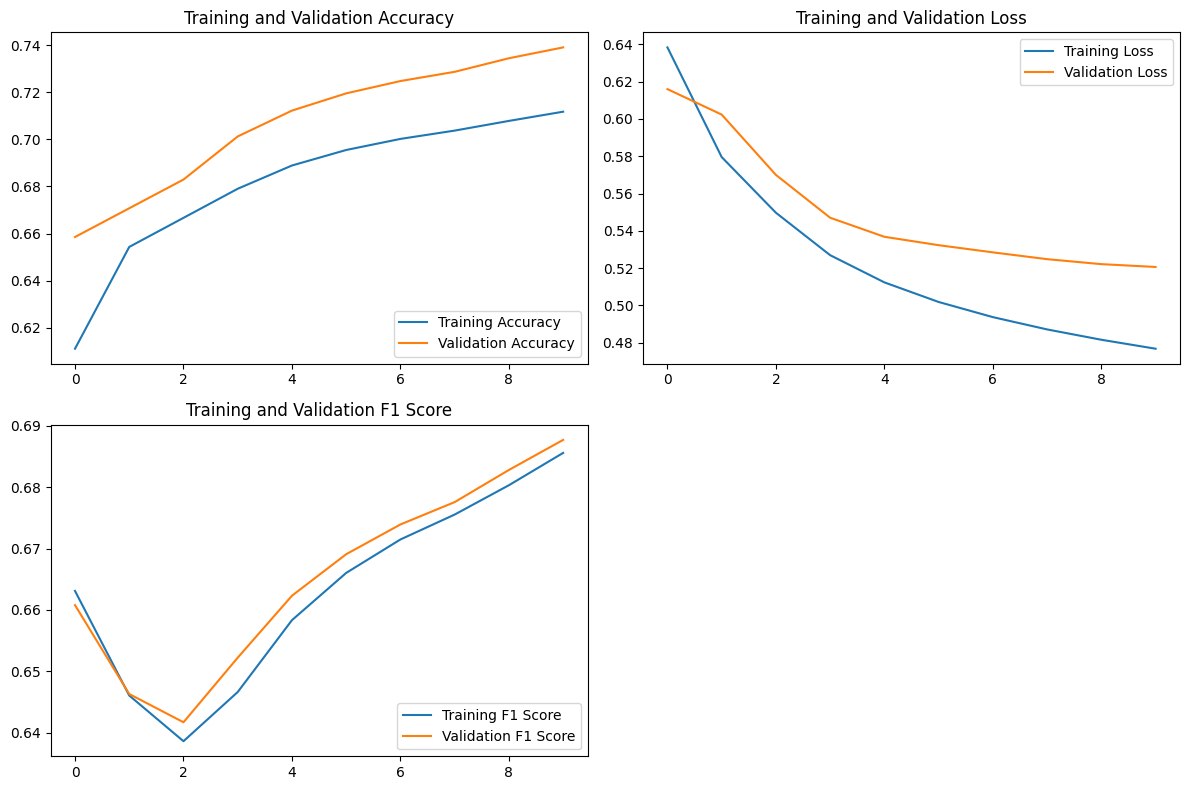

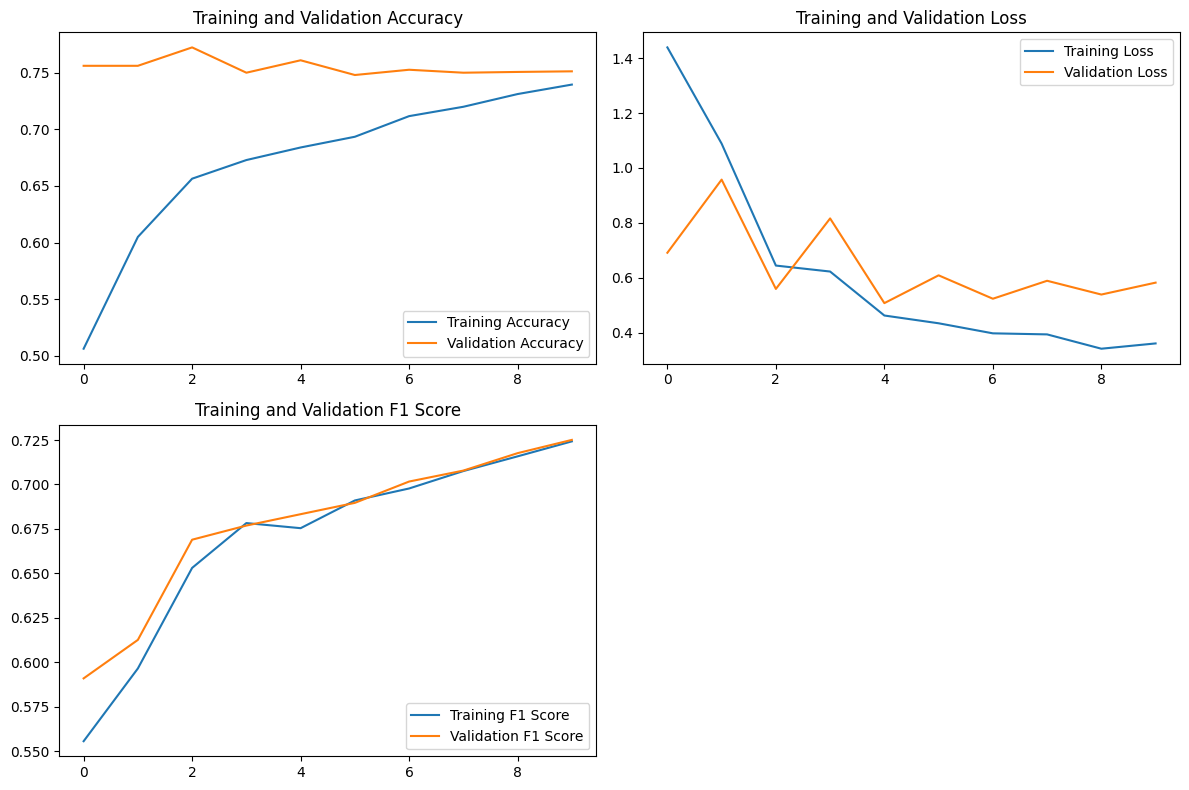

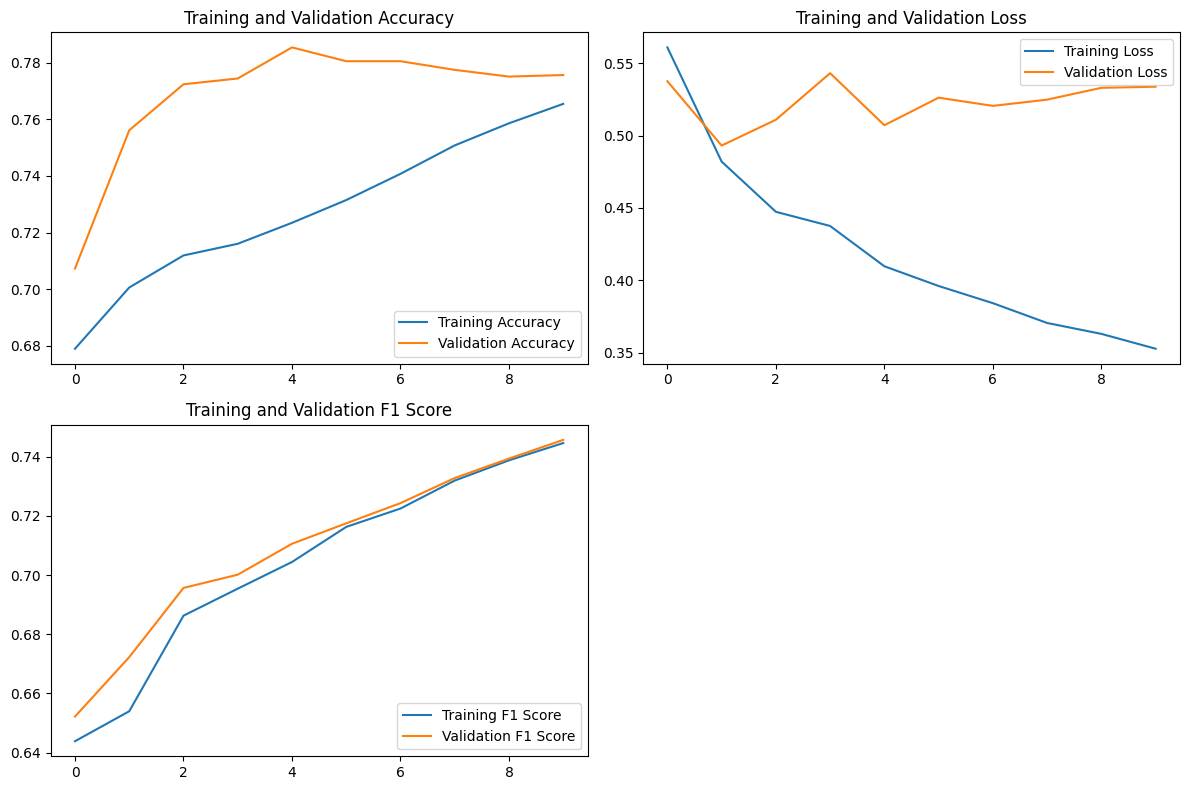

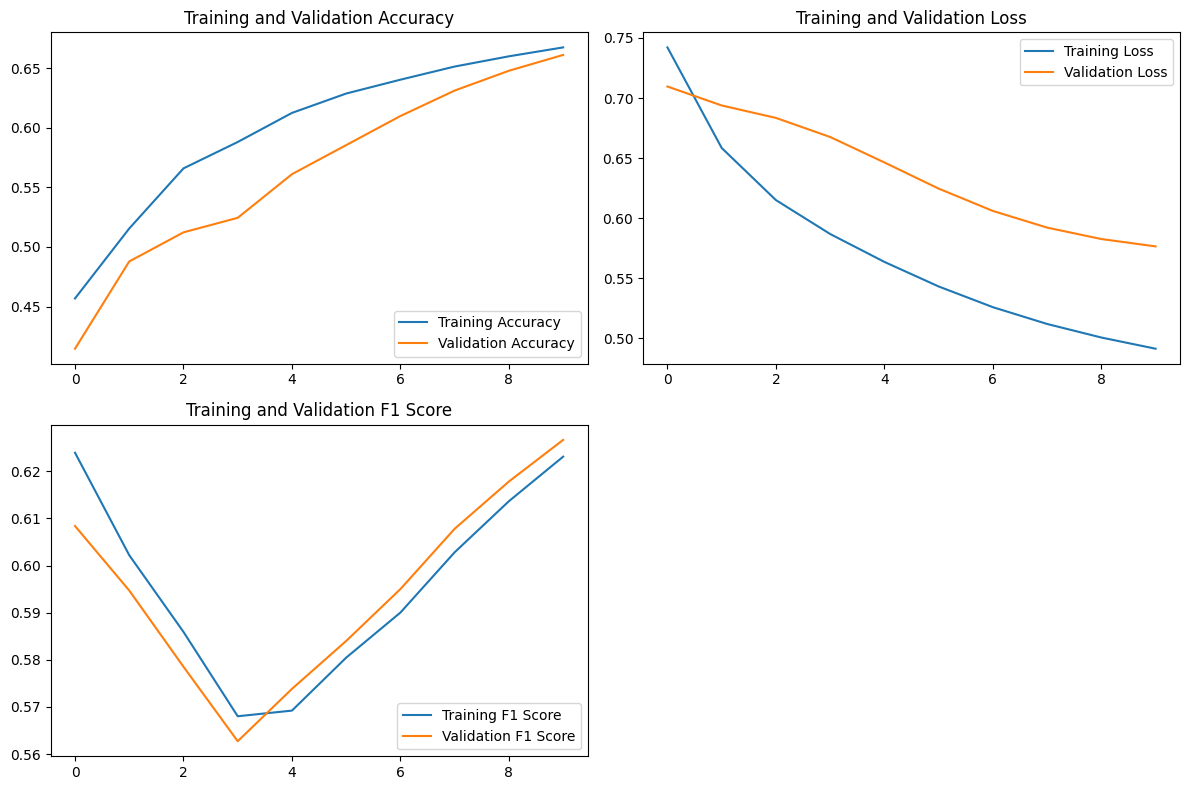

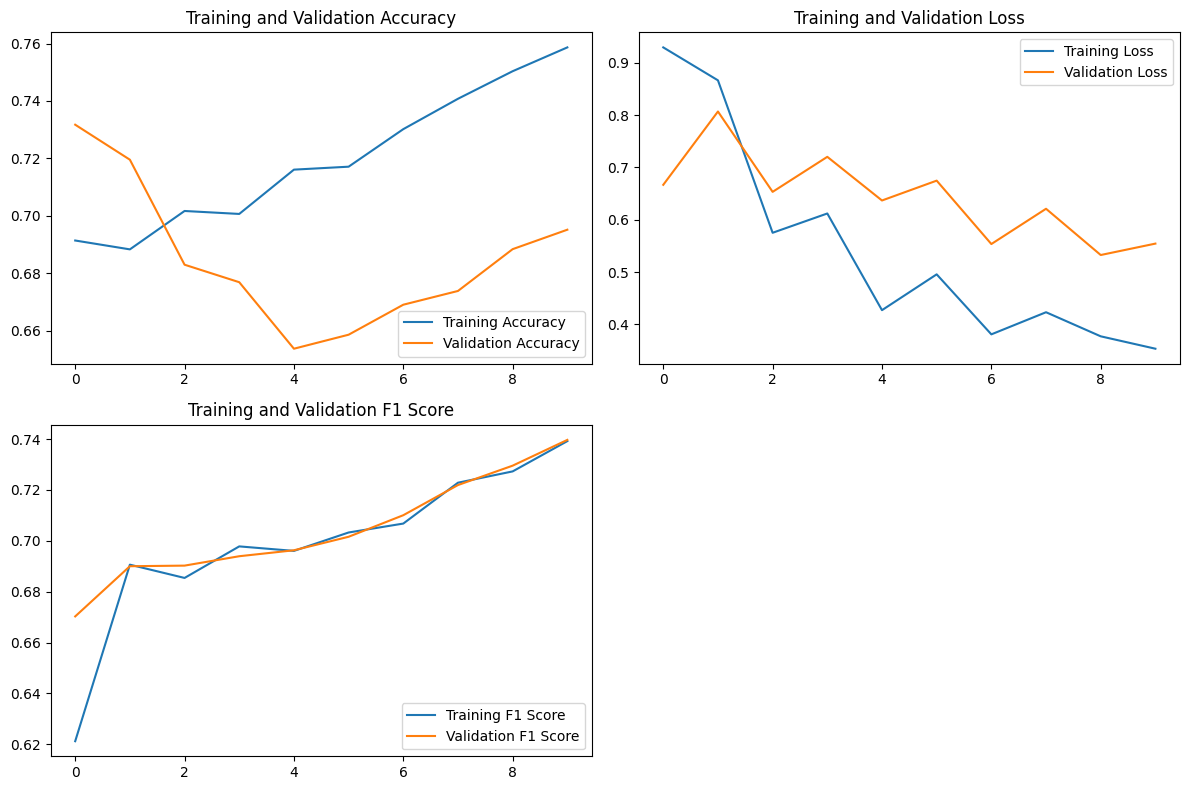

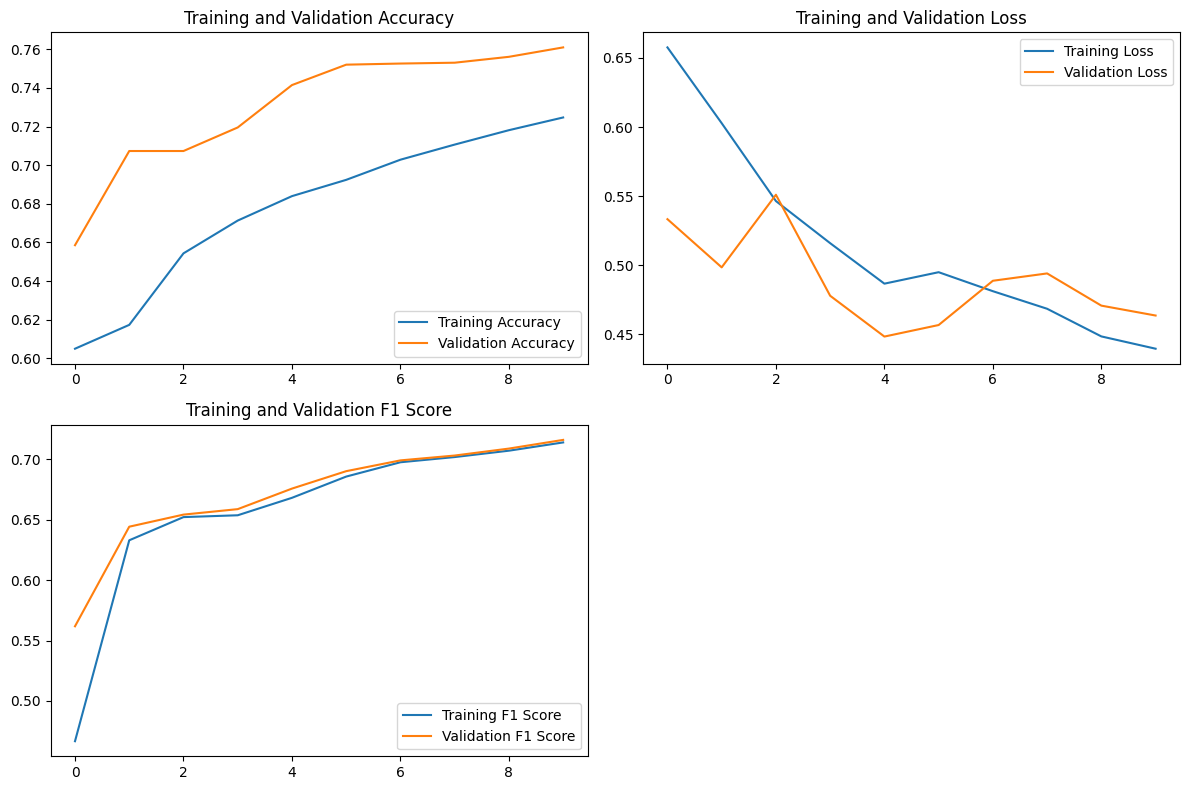

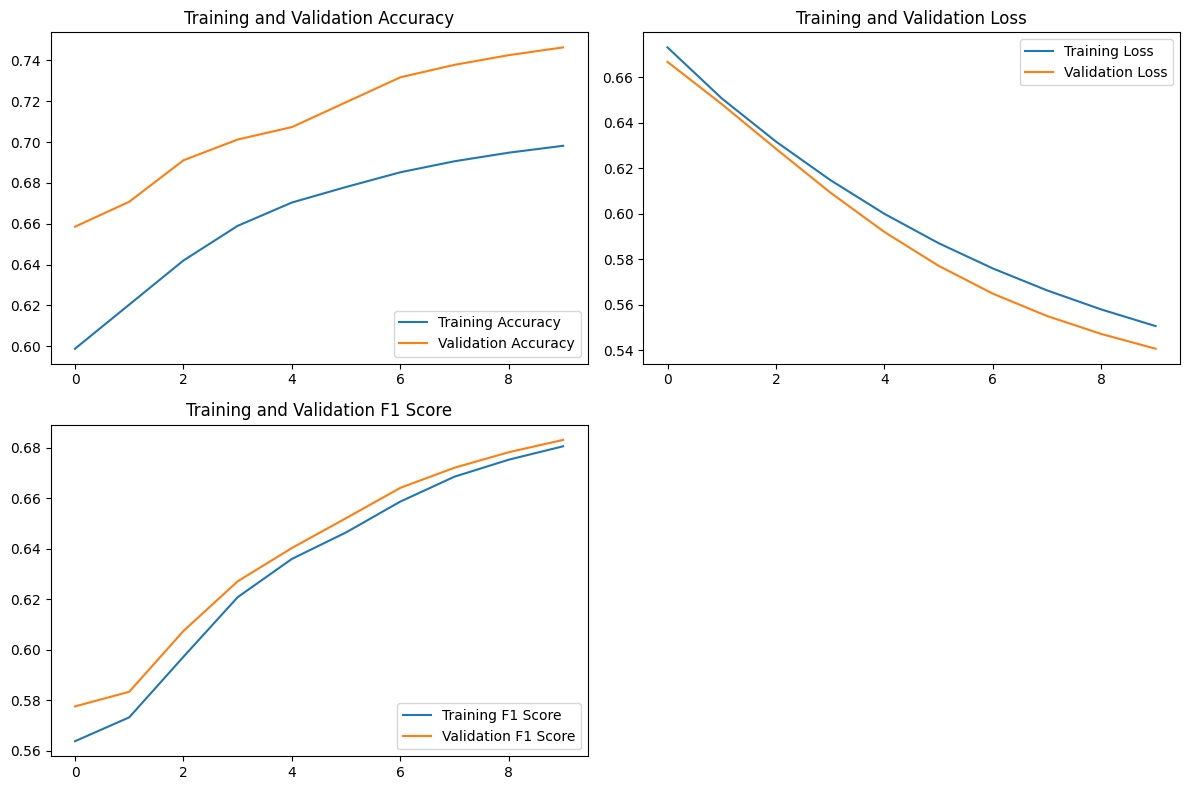

In [5]:
# Set seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters to tune
param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'num_epochs': [10],
    'batch_size': [8, 16, 32, 64],
}

# Create a parameter grid
grid = ParameterGrid(param_grid)

# Initialize a list to store the results
results = []

# Split dataset into training and testing
train_size = int(0.8 * len(F_dataset))  # 80% of the data for training
test_size = len(F_dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(F_dataset, [train_size, test_size])

# For each combination of hyperparameters
for params in grid:
    # Initialize the DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'])
    test_dataloader = DataLoader(test_dataset, batch_size=params['batch_size'])

    # Initialize the model (pre-trained MobileNetV2)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)  # Two classes for classification

    F_model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create the optimizer
    optimizer = Adam(learning_rate=params['lr'])

    # Define the loss function
    loss_fn = SparseCategoricalCrossentropy()

    # Define the metrics
    train_acc_metric = SparseCategoricalAccuracy()
    val_acc_metric = SparseCategoricalAccuracy()

    train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s = train_cycle(F_model, optimizer, loss_fn, train_acc_metric, val_acc_metric, train_dataloader, test_dataloader, epochs=params['num_epochs'])
    # Extract the last element and convert it to a Python native type if necessary
    last_val_loss = float(val_losses[-1].numpy()) if isinstance(val_losses[-1], tf.Tensor) else val_losses[-1]
    last_val_accuracy = float(val_accs[-1].numpy()) if isinstance(val_accs[-1], tf.Tensor) else val_accs[-1]
    last_val_f1 = float(val_f1s[-1].numpy()) if isinstance(val_f1s[-1], tf.Tensor) else val_f1s[-1]

    name = 'F_lr' + str(params['lr']) + '_bs_' + str(params['batch_size'])
    plot_metrics(train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s, plot_name=name)

    # Store the results
    results.append({
        'lr': params['lr'],
        'batch_size': params['batch_size'],
        'num_epochs': params['num_epochs'],
        'eval_loss': last_val_loss,
        'acc': last_val_accuracy,
        'f1': last_val_f1
    })

with open('hyperparameter_tuning/audio_hyperparameter_tuning_F.json', 'w') as f:
    json.dump(results, f, indent=4)


Start of epoch 0
Training acc over epoch: 0.5475
Training F1 score over epoch: 0.5622
Training loss over epoch: 1.1379
Validation acc: 0.6222
Validation F1 score: 0.5847
Validation loss: 0.7560

Start of epoch 1
Training acc over epoch: 0.6103
Training F1 score over epoch: 0.6331
Training loss over epoch: 0.6190
Validation acc: 0.6222
Validation F1 score: 0.6366
Validation loss: 0.7283

Start of epoch 2
Training acc over epoch: 0.6453
Training F1 score over epoch: 0.6627
Training loss over epoch: 0.5857
Validation acc: 0.6222
Validation F1 score: 0.6629
Validation loss: 0.7710

Start of epoch 3
Training acc over epoch: 0.6648
Training F1 score over epoch: 0.6781
Training loss over epoch: 0.5599
Validation acc: 0.6167
Validation F1 score: 0.6764
Validation loss: 0.7779

Start of epoch 4
Training acc over epoch: 0.6810
Training F1 score over epoch: 0.6903
Training loss over epoch: 0.5361
Validation acc: 0.6133
Validation F1 score: 0.6884
Validation loss: 0.7952

Start of epoch 5
Trainin

KeyboardInterrupt: 

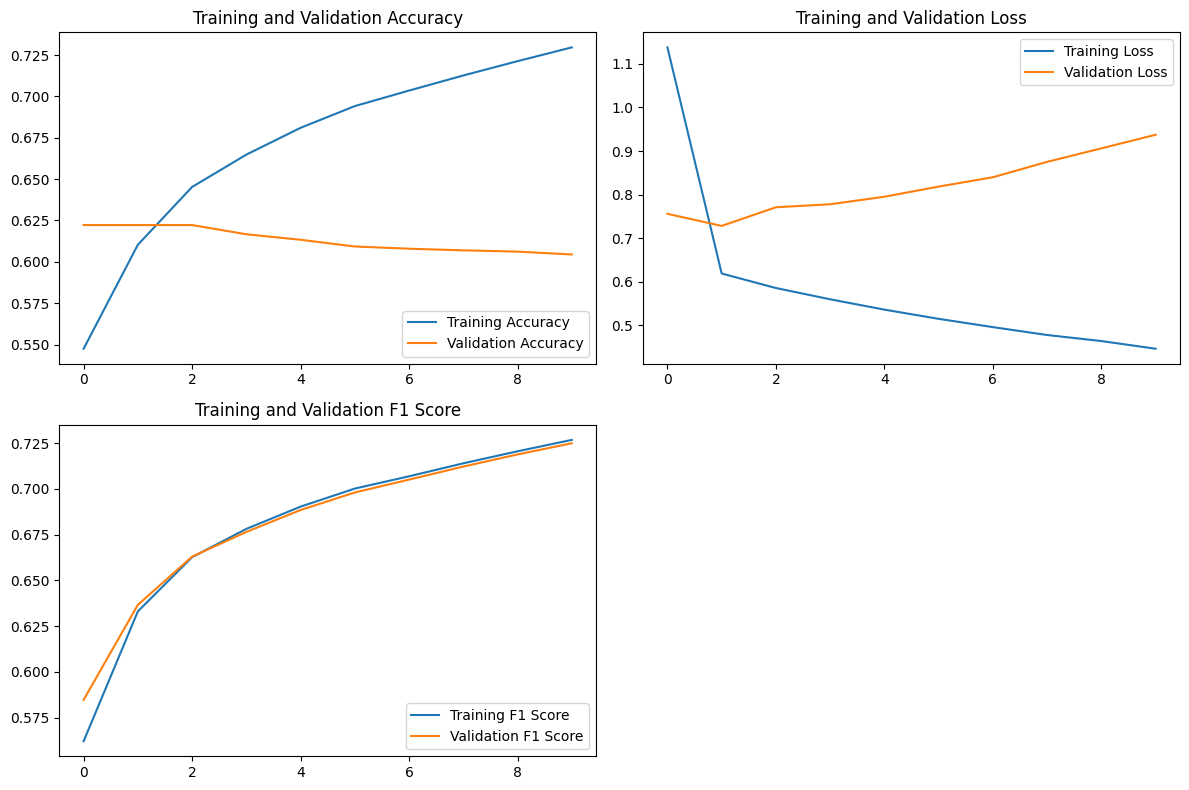

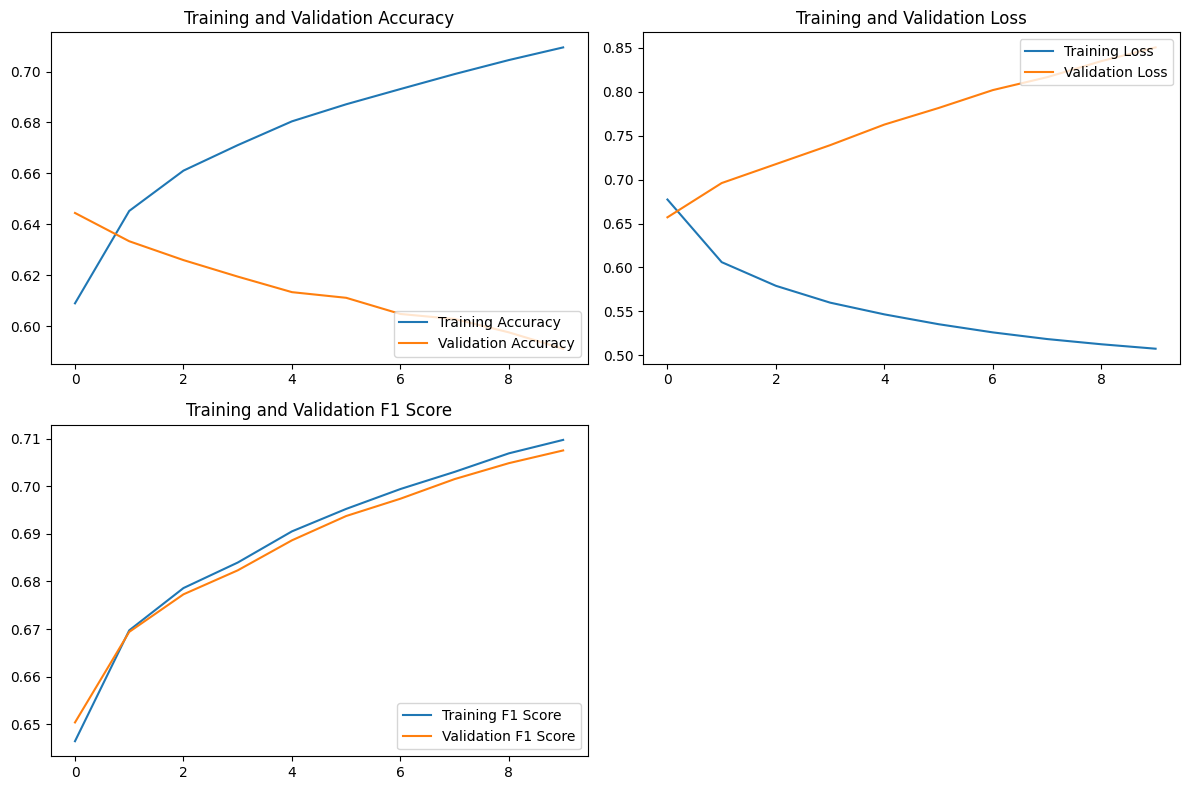

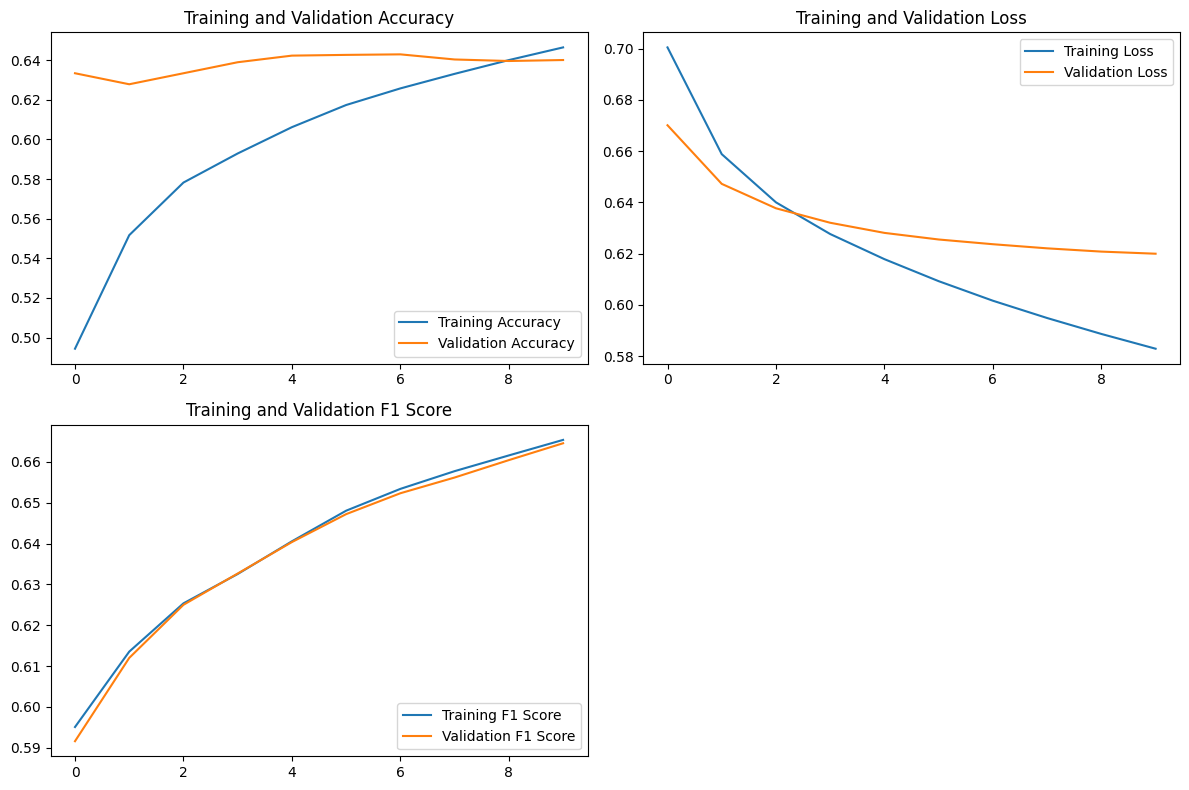

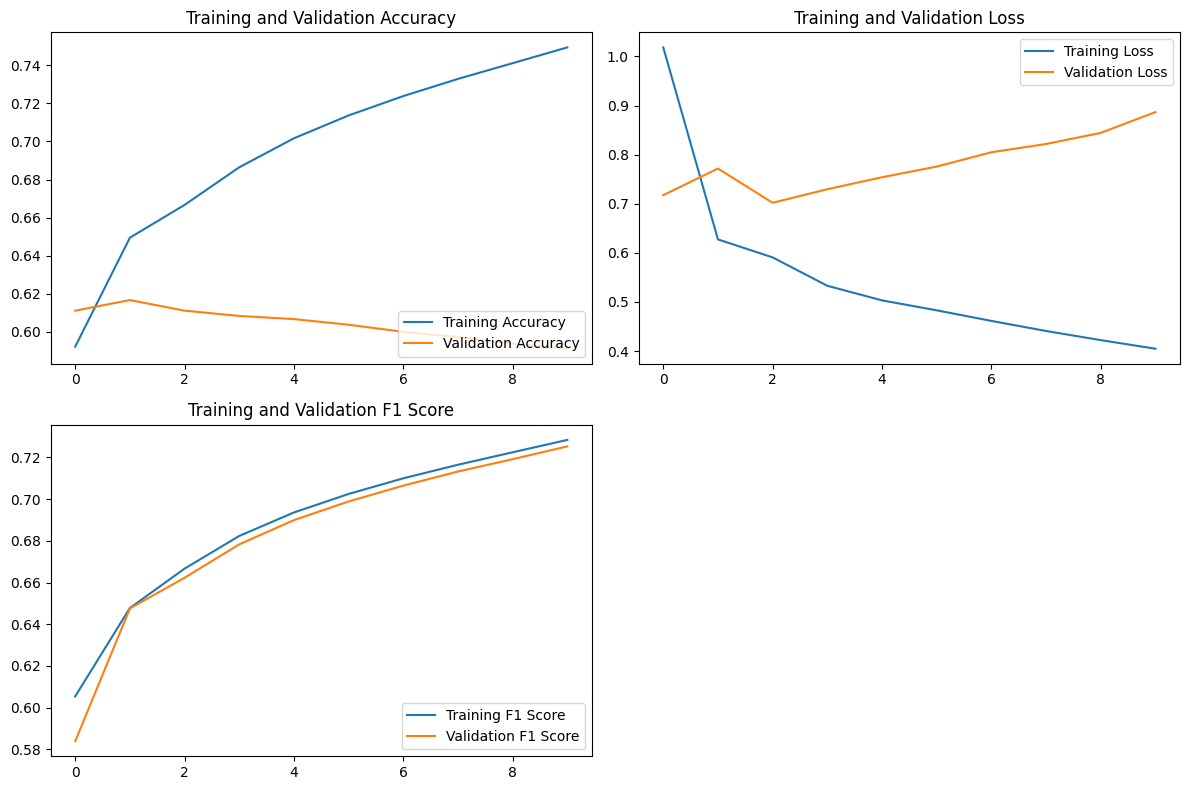

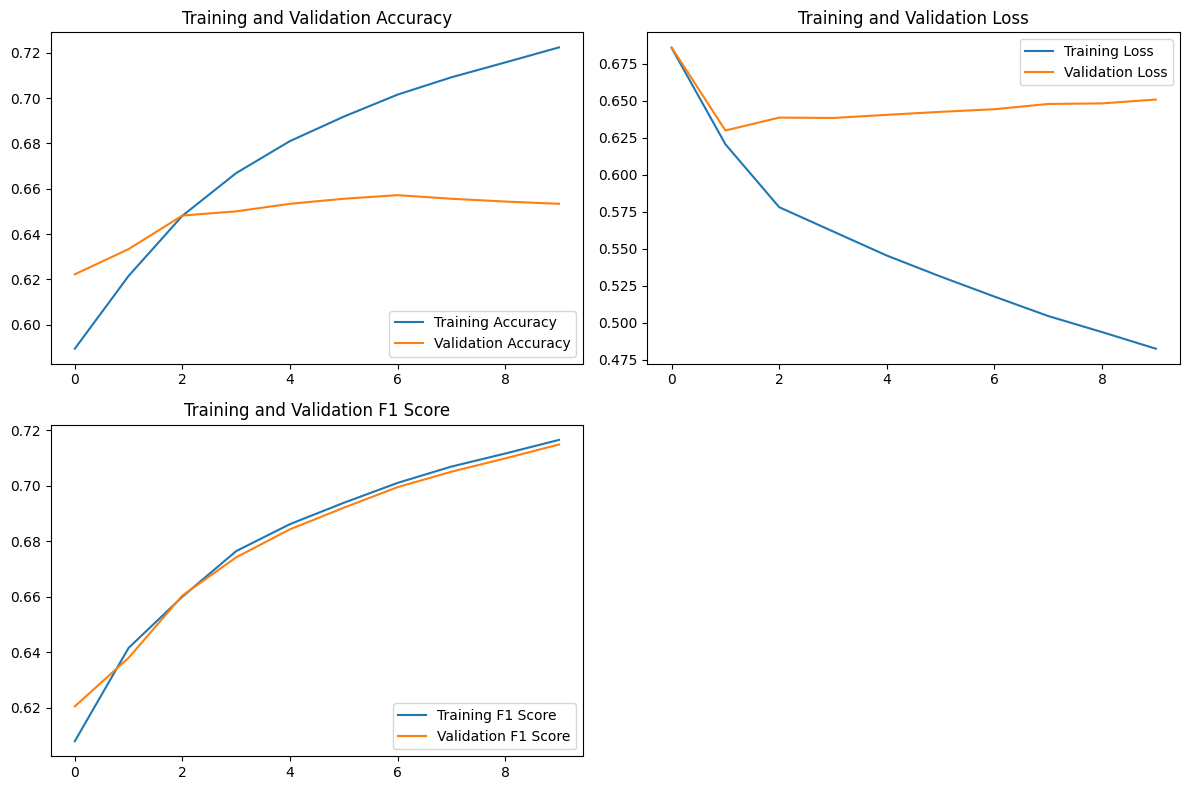

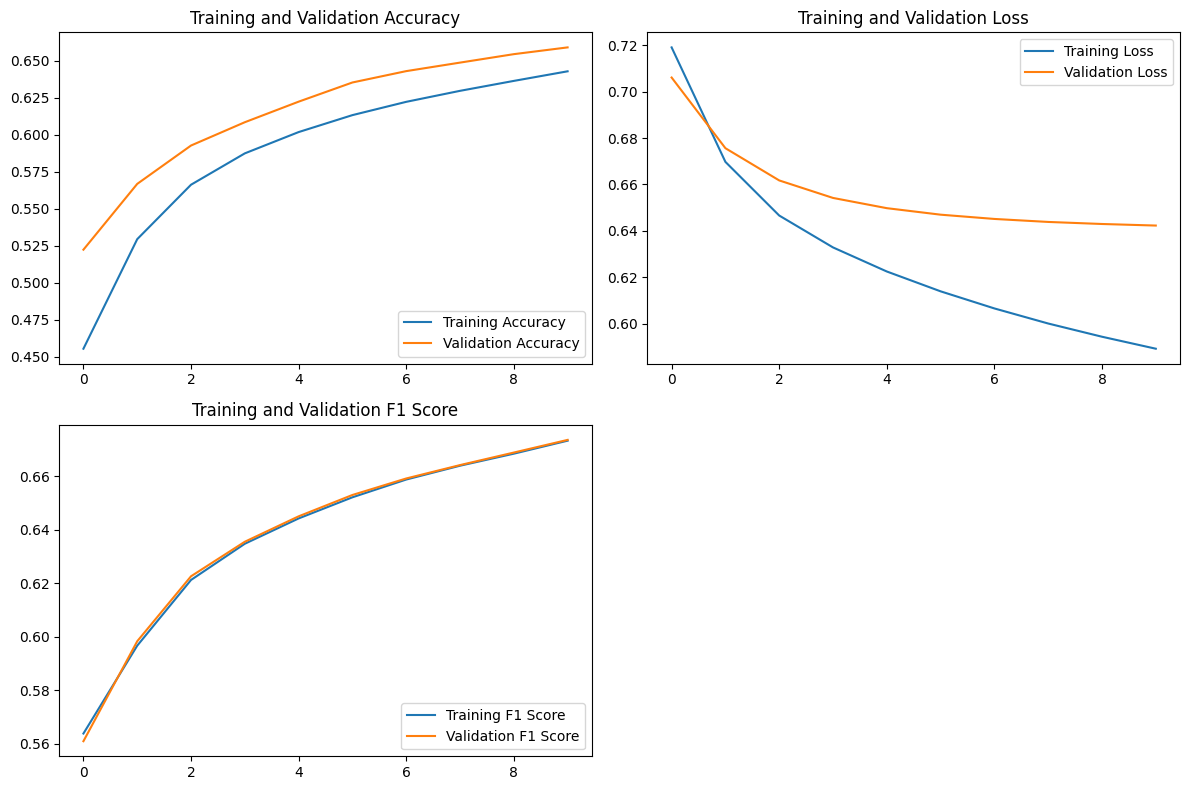

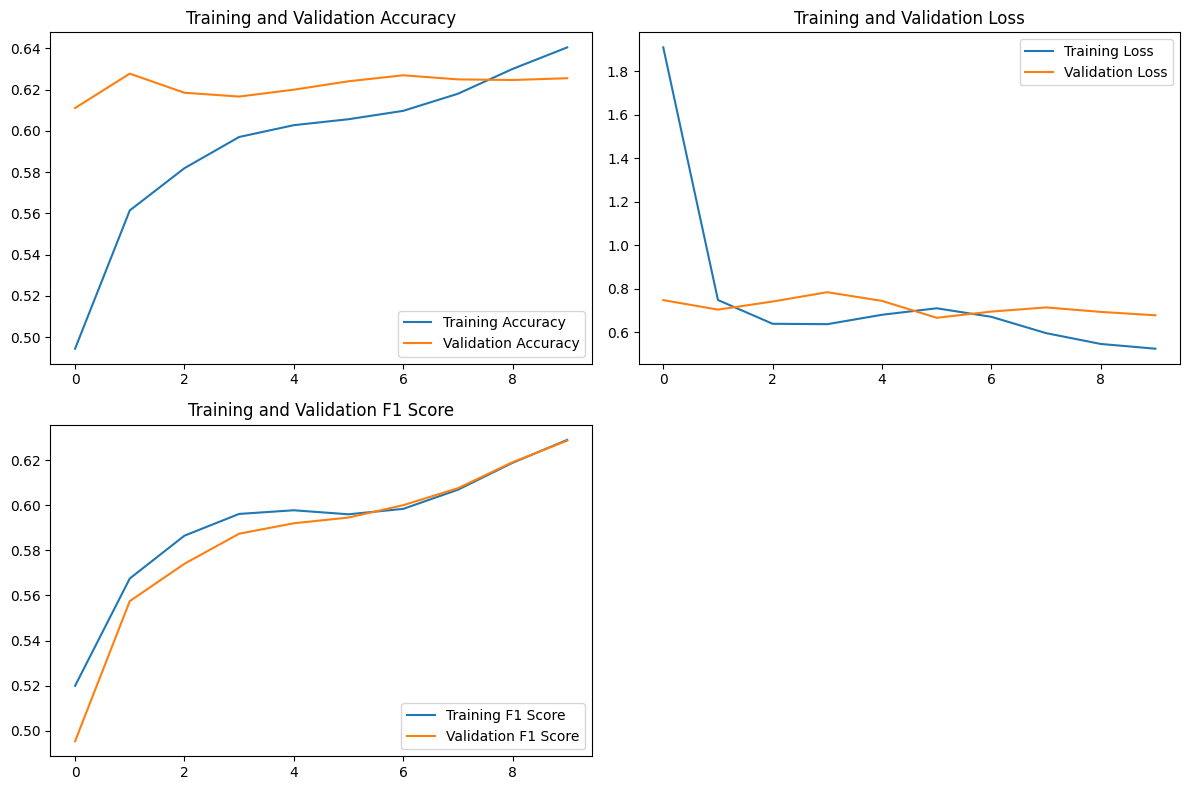

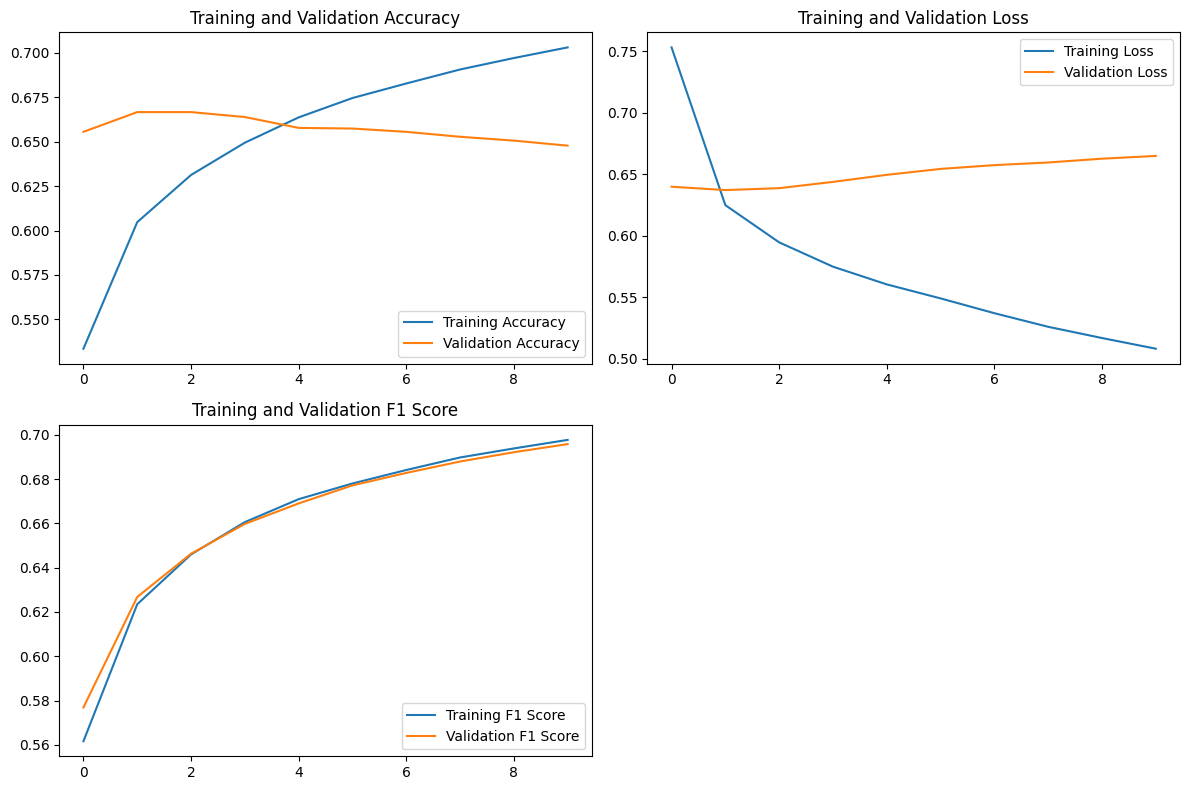

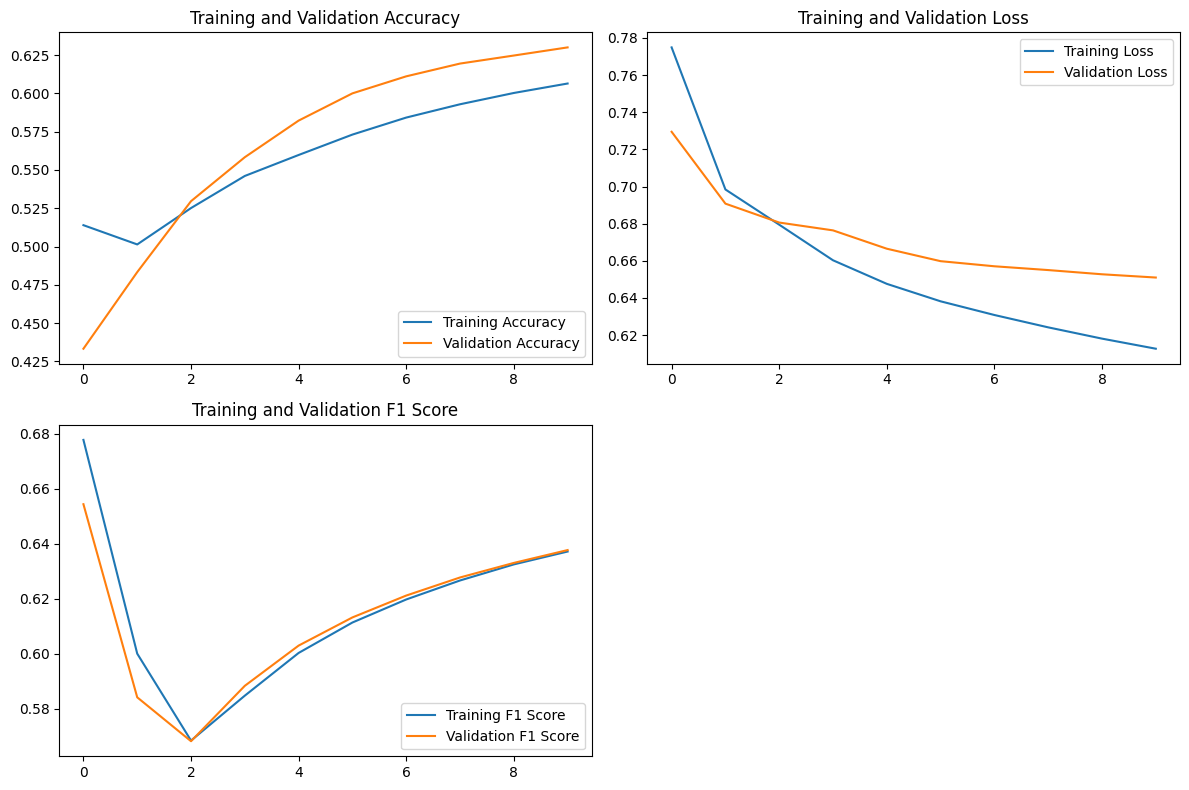

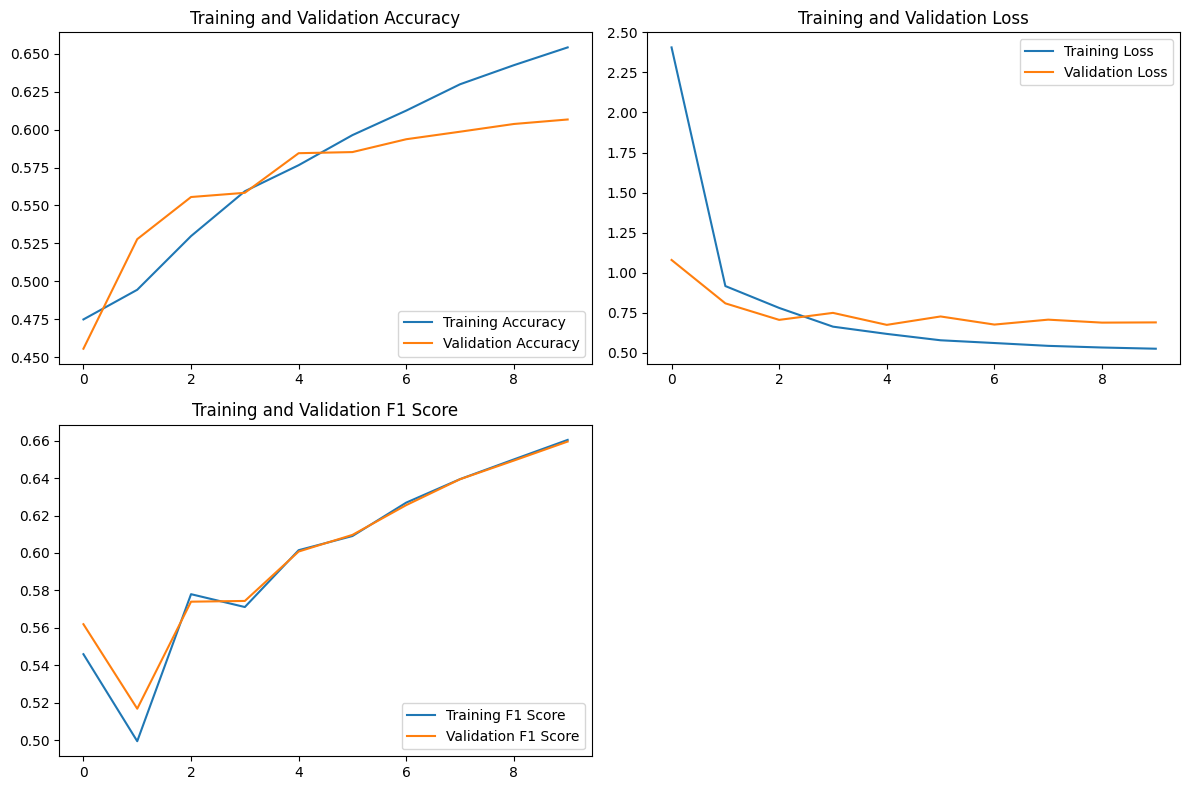

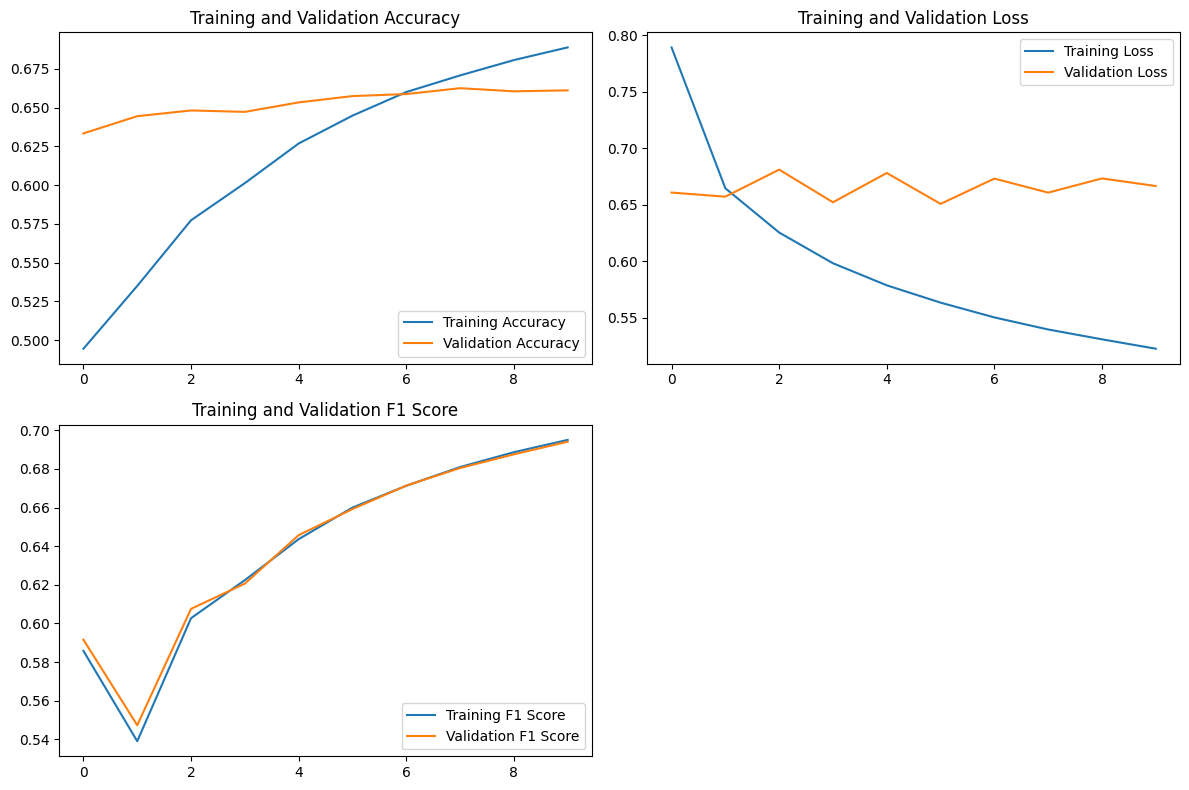

In [7]:
# Set seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters to tune
param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'num_epochs': [10],
    'batch_size': [8, 16, 32, 64],
    'dropout_prob': [0]
}

# Create a parameter grid
grid = ParameterGrid(param_grid)

# Initialize a list to store the results
results = []

# Split dataset into training and testing
train_size = int(0.8 * len(M_dataset))  # 80% of the data for training
test_size = len(M_dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(M_dataset, [train_size, test_size])

# For each combination of hyperparameters
for params in grid:
    # Initialize the DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'])
    test_dataloader = DataLoader(test_dataset, batch_size=params['batch_size'])

    # Initialize the model (pre-trained MobileNetV2)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)  # Two classes for classification

    M_model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create the optimizer
    optimizer = Adam(learning_rate=params['lr'])

    # Define the loss function
    loss_fn = SparseCategoricalCrossentropy()

    # Define the metrics
    train_acc_metric = SparseCategoricalAccuracy()
    val_acc_metric = SparseCategoricalAccuracy()

    train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s = train_cycle(M_model, optimizer, loss_fn, train_acc_metric, val_acc_metric, train_dataloader, test_dataloader, epochs=params['num_epochs'])
    # Extract the last element and convert it to a Python native type if necessary
    last_val_loss = float(val_losses[-1].numpy()) if isinstance(val_losses[-1], tf.Tensor) else val_losses[-1]
    last_val_accuracy = float(val_accs[-1].numpy()) if isinstance(val_accs[-1], tf.Tensor) else val_accs[-1]
    last_val_f1 = float(val_f1s[-1].numpy()) if isinstance(val_f1s[-1], tf.Tensor) else val_f1s[-1]
    
    name = 'M_lr' + str(params['lr']) + '_bs_' + str(params['batch_size'])
    plot_metrics(train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s, plot_name=name)

    # Store the results
    results.append({
        'lr': params['lr'],
        'batch_size': params['batch_size'],
        'num_epochs': params['num_epochs'],
        'eval_loss': last_val_loss,
        'acc': last_val_accuracy,
        'f1': last_val_f1
    })

with open('hyperparameter_tuning/audio_hyperparameter_tuning_M.json', 'w') as f:
    json.dump(results, f, indent=4)